In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightgbm xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

# Convert scores to 1-100 scale and discretize into 10 levels
df['reason_score_100'] = df['reason_score'] * 10  # Convert to 1-100 scale
df['reason_score_discrete'] = pd.qcut(df['reason_score_100'], q=10, labels=False, duplicates='drop')

# Enhanced feature engineering focusing on relative comparisons
def engineer_features(df):
    # Basic numeric conversion
    df['Impact_Factor'] = pd.to_numeric(df['Impact_Factor'], errors='coerce')
    df['original_altmetric_score'] = pd.to_numeric(df['original_altmetric_score'], errors='coerce')
    df['original_cited_by_posts_count'] = pd.to_numeric(df['original_cited_by_posts_count'], errors='coerce')

    # Fill NaN with 0
    df = df.fillna(0)

    # Create percentile ranks for each metric
    df['impact_factor_rank'] = df['Impact_Factor'].rank(pct=True)
    df['altmetric_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['citation_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create interaction features based on ranks
    df['impact_citation_rank'] = df['impact_factor_rank'] * df['citation_rank']
    df['impact_altmetric_rank'] = df['impact_factor_rank'] * df['altmetric_rank']

    # Relative position features
    df['relative_citation_impact'] = df['original_cited_by_posts_count'] / (df['Impact_Factor'] + 1)
    df['relative_altmetric_impact'] = df['original_altmetric_score'] / (df['Impact_Factor'] + 1)

    return df

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features focusing on relative positions
features = [
    'impact_factor_rank',
    'altmetric_rank',
    'citation_rank',
    'impact_citation_rank',
    'impact_altmetric_rank',
    'relative_citation_impact',
    'relative_altmetric_impact',
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count'
]

# Prepare data
X = df_engineered[features].copy()
y = df['reason_score_discrete']  # Using discretized scores

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create query groups based on discrete scores
def create_query_groups(y):
    return np.bincount(y.astype(int))[np.nonzero(np.bincount(y.astype(int)))]

train_query_groups = create_query_groups(y_train)
test_query_groups = create_query_groups(y_test)

# Initialize model with ranking-specific parameters
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="gbdt",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    importance_type="gain",
    random_state=42,
    label_gain=list(range(10))  # 10 levels (0-9)
)

# Train model
ranker.fit(
    X_train,
    y_train,
    group=train_query_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_query_groups],
    eval_metric='ndcg'
)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': ranker.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))

def analyze_sample_rankings(X_test, y_test, df_original, model, n_samples=10):
    # Get predictions for all test data
    predictions = model.predict(X_test)

    # Randomly sample n_samples entries
    random_indices = np.random.choice(len(X_test), n_samples, replace=False)

    # Get the sampled data
    X_sample = X_test.iloc[random_indices]
    y_sample = y_test.iloc[random_indices]

    # Get predictions for just these samples
    sample_predictions = model.predict(X_sample)

    # Create results DataFrame
    results = pd.DataFrame({
        'Title': df_original['Title'].iloc[y_sample.index],
        'Predicted_Score': sample_predictions,
        'Actual_Score': df_original['reason_score'].iloc[y_sample.index],
        'Original_Features': [
            f"IF:{X_sample['Impact_Factor'].iloc[i]:.2f}, "
            f"Alt:{X_sample['original_altmetric_score'].iloc[i]:.2f}, "
            f"Cit:{X_sample['original_cited_by_posts_count'].iloc[i]}"
            for i in range(len(X_sample))
        ]
    })

    # Add rankings (1-10) for just these samples
    results['Predicted_Rank'] = results['Predicted_Score'].rank(ascending=False)
    results['True_Rank'] = results['Actual_Score'].rank(ascending=False)

    # Sort by true rank to show ground truth order
    results = results.sort_values('True_Rank')

    print("\nComparison of Rankings for 10 Random Papers:")
    print("=" * 100)
    print("\nOrdered by Ground Truth Rank:")
    for idx, row in results.iterrows():
        print(f"\nTrue Rank: {int(row['True_Rank'])} | Predicted Rank: {int(row['Predicted_Rank'])}")
        print(f"Title: {row['Title']}")
        print(f"True Score: {row['Actual_Score']:.2f} | Predicted Score: {row['Predicted_Score']:.2f}")
        print(f"Features: {row['Original_Features']}")
        print("-" * 80)

    # Calculate rank correlation for just these 10 samples
    rank_correlation = results['Predicted_Rank'].corr(results['True_Rank'], method='spearman')
    print(f"\nSpearman Rank Correlation for these 10 papers: {rank_correlation:.3f}")

    # Calculate perfect matches and close matches
    perfect_matches = (results['Predicted_Rank'] == results['True_Rank']).sum()
    close_matches = (abs(results['Predicted_Rank'] - results['True_Rank']) <= 1).sum()

    print(f"Perfect Rank Matches: {perfect_matches} out of 10")
    print(f"Ranks Off by ≤1 Position: {close_matches} out of 10")

    return results

# Run the analysis
sample_results = analyze_sample_rankings(X_test, y_test, df, ranker)

# Calculate NDCG@k for different k values
predictions_all = ranker.predict(X_test)
for k in [5, 10, 20]:
    ndcg = ndcg_score(
        y_true=y_test.values.reshape(1, -1),
        y_score=predictions_all.reshape(1, -1),
        k=k
    )
    print(f"\nNDCG@{k}: {ndcg:.4f}")

# Save the model
import pickle

model_data = {
    'ranker': ranker,
    'feature_scaler': StandardScaler(),
    'features': features
}

with open('ranking_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

# Convert scores to 1-100 scale with more granularity
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)  # Ensure scores are between 1-100
# Create 20 discrete levels for better granularity
df['reason_score_discrete'] = pd.qcut(df['reason_score_100'], q=20, labels=False, duplicates='drop')

def engineer_features(df):
    # Basic numeric conversion
    df['Impact_Factor'] = pd.to_numeric(df['Impact_Factor'], errors='coerce')
    df['original_altmetric_score'] = pd.to_numeric(df['original_altmetric_score'], errors='coerce')
    df['original_cited_by_posts_count'] = pd.to_numeric(df['original_cited_by_posts_count'], errors='coerce')

    # Fill NaN with 0
    df = df.fillna(0)

    # Create percentile ranks for each metric
    df['impact_factor_rank'] = df['Impact_Factor'].rank(pct=True)
    df['altmetric_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['citation_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create interaction features based on ranks
    df['impact_citation_rank'] = df['impact_factor_rank'] * df['citation_rank']
    df['impact_altmetric_rank'] = df['impact_factor_rank'] * df['altmetric_rank']

    # Relative position features with normalized scores
    df['relative_citation_impact'] = df['original_cited_by_posts_count'] / (df['Impact_Factor'] + 1)
    df['relative_altmetric_impact'] = df['original_altmetric_score'] / (df['Impact_Factor'] + 1)

    return df

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'impact_factor_rank',
    'altmetric_rank',
    'citation_rank',
    'impact_citation_rank',
    'impact_altmetric_rank',
    'relative_citation_impact',
    'relative_altmetric_impact',
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count'
]

# Prepare data
X = df_engineered[features].copy()
y = df['reason_score_discrete']  # Using 20-level discretized scores

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create query groups based on discrete scores
def create_query_groups(y):
    return np.bincount(y.astype(int))[np.nonzero(np.bincount(y.astype(int)))]

train_query_groups = create_query_groups(y_train)
test_query_groups = create_query_groups(y_test)

# Initialize model
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="gbdt",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    importance_type="gain",
    random_state=42,
    label_gain=list(range(20))  # 20 levels for more granularity
)

# Train model
ranker.fit(
    X_train,
    y_train,
    group=train_query_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_query_groups],
    eval_metric='ndcg'
)

def analyze_sample_rankings(X_test, y_test, df_original, model, n_samples=10):
    # Get predictions for all test data
    predictions = model.predict(X_test)

    # Randomly sample n_samples entries
    random_indices = np.random.choice(len(X_test), n_samples, replace=False)

    # Get the sampled data
    X_sample = X_test.iloc[random_indices]
    y_sample = y_test.iloc[random_indices]

    # Get predictions for just these samples
    sample_predictions = model.predict(X_sample)

    # Create results DataFrame
    results = pd.DataFrame({
        'Title': df_original['Title'].iloc[y_sample.index],
        'Predicted_Score': sample_predictions,
        'Actual_Score': df_original['reason_score_100'].iloc[y_sample.index],  # Using 100-scale scores
        'Original_Features': [
            f"IF:{X_sample['Impact_Factor'].iloc[i]:.2f}, "
            f"Alt:{X_sample['original_altmetric_score'].iloc[i]:.2f}, "
            f"Cit:{X_sample['original_cited_by_posts_count'].iloc[i]}"
            for i in range(len(X_sample))
        ]
    })

    # Add rankings (1-10) for just these samples
    results['Predicted_Rank'] = results['Predicted_Score'].rank(ascending=False)
    results['True_Rank'] = results['Actual_Score'].rank(ascending=False)

    # Sort by true rank to show ground truth order
    results = results.sort_values('True_Rank')

    print("\nComparison of Rankings for 10 Random Papers:")
    print("=" * 100)
    print("\nOrdered by Ground Truth Rank:")
    for idx, row in results.iterrows():
        print(f"\nTrue Rank: {int(row['True_Rank'])} | Predicted Rank: {int(row['Predicted_Rank'])}")
        print(f"Title: {row['Title']}")
        print(f"True Score: {row['Actual_Score']:.1f} | Predicted Score: {row['Predicted_Score']:.2f}")
        print(f"Features: {row['Original_Features']}")
        print("-" * 80)

    # Calculate rank correlation for just these 10 samples
    rank_correlation = results['Predicted_Rank'].corr(results['True_Rank'], method='spearman')
    print(f"\nSpearman Rank Correlation for these 10 papers: {rank_correlation:.3f}")

    # Calculate perfect matches and close matches
    perfect_matches = (results['Predicted_Rank'] == results['True_Rank']).sum()
    close_matches = (abs(results['Predicted_Rank'] - results['True_Rank']) <= 1).sum()

    print(f"Perfect Rank Matches: {perfect_matches} out of 10")
    print(f"Ranks Off by ≤1 Position: {close_matches} out of 10")

    return results

# Run the analysis
sample_results = analyze_sample_rankings(X_test, y_test, df, ranker)

# Calculate NDCG@k for different k values
predictions_all = ranker.predict(X_test)
for k in [5, 10, 20]:
    ndcg = ndcg_score(
        y_true=y_test.values.reshape(1, -1),
        y_score=predictions_all.reshape(1, -1),
        k=k
    )
    print(f"\nNDCG@{k}: {ndcg:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 10

Comparison of Rankings for 10 Random Papers:

Ordered by Ground Truth Rank:

True Rank: 2 | Predicted Rank: 5
Title: Meta analysis of clinical prognosis of radiofrequency ablation versus partial nephrectomy in the treatment of early renal cell carcinoma
True Score: 100.0 | Predicted Score: -1.26
Features: IF:3.50, Alt:0.25, Cit:1.0
--------------------------------------------------------------------------------

True Rank: 2 | Predicted Rank: 7
Title: Simple Sequence Repeat and S-locus Genotyping to Explore Genetic Variability in Polyploid Prunus spinosa and P. insititia
True Score: 100.0 | Predicted Score: -1.62
Features: IF:2.10, Alt:5.04, Cit:1.0
-----------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

# Convert scores to 1-100 scale
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)

# Enhanced feature engineering
def engineer_features(df):
    # Basic numeric conversion
    df['Impact_Factor'] = pd.to_numeric(df['Impact_Factor'], errors='coerce')
    df['original_altmetric_score'] = pd.to_numeric(df['original_altmetric_score'], errors='coerce')
    df['original_cited_by_posts_count'] = pd.to_numeric(df['original_cited_by_posts_count'], errors='coerce')

    # Fill NaN with 0
    df = df.fillna(0)

    # Create percentile ranks
    df['impact_factor_rank'] = df['Impact_Factor'].rank(pct=True)
    df['altmetric_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['citation_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Severity-weighted features
    severity_weight = df['reason_score_100'] / 100
    df['severity_weighted_impact'] = df['Impact_Factor'] * severity_weight
    df['severity_weighted_altmetric'] = df['original_altmetric_score'] * severity_weight
    df['severity_weighted_citation'] = df['original_cited_by_posts_count'] * severity_weight

    return df

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'impact_factor_rank',
    'altmetric_rank',
    'citation_rank',
    'severity_weighted_impact',
    'severity_weighted_altmetric',
    'severity_weighted_citation',
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count'
]

# Prepare data
X = df_engineered[features].copy()

# Create severity groups (8 groups)
y_groups = pd.qcut(df['reason_score_100'], q=8, labels=False, duplicates='drop')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_groups, test_size=0.2, random_state=42, stratify=y_groups
)

# Create query groups
def create_query_groups(y):
    groups = []
    for score in range(8):  # 8 severity groups
        count = np.sum(y == score)
        if count > 0:
            groups.append(count)
    return np.array(groups)

train_query_groups = create_query_groups(y_train)
test_query_groups = create_query_groups(y_test)

# Initialize model
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="gbdt",
    n_estimators=200,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=31,
    importance_type="gain",
    random_state=42,
    label_gain=list(range(8))  # 8 severity groups
)

# Train model
ranker.fit(
    X_train,
    y_train,
    group=train_query_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_query_groups],
    eval_metric='ndcg'
)

def analyze_sample_rankings(X_test, y_test, df_original, model, n_samples=10):
    predictions = model.predict(X_test)

    # Randomly sample n_samples entries
    random_indices = np.random.choice(len(X_test), n_samples, replace=False)

    X_sample = X_test.iloc[random_indices]

    # Create results DataFrame
    results = pd.DataFrame({
        'Title': df_original['Title'].iloc[X_sample.index],
        'Predicted_Score': model.predict(X_sample),
        'Actual_Score': df_original['reason_score_100'].iloc[X_sample.index],
        'Original_Features': [
            f"IF:{X_sample['Impact_Factor'].iloc[i]:.2f}, "
            f"Alt:{X_sample['original_altmetric_score'].iloc[i]:.2f}, "
            f"Cit:{X_sample['original_cited_by_posts_count'].iloc[i]}"
            for i in range(len(X_sample))
        ]
    })

    # Add rankings
    results['Predicted_Rank'] = results['Predicted_Score'].rank(ascending=False)
    results['True_Rank'] = results['Actual_Score'].rank(ascending=False)

    # Sort by true rank
    results = results.sort_values('True_Rank')

    print("\nComparison of Rankings for 10 Random Papers:")
    print("=" * 100)
    for idx, row in results.iterrows():
        print(f"\nTrue Rank: {int(row['True_Rank'])} | Predicted Rank: {int(row['Predicted_Rank'])}")
        print(f"Title: {row['Title']}")
        print(f"True Score: {row['Actual_Score']:.1f} | Predicted Score: {row['Predicted_Score']:.2f}")
        print(f"Features: {row['Original_Features']}")
        print("-" * 80)

    # Calculate metrics
    rank_correlation = results['Predicted_Rank'].corr(results['True_Rank'], method='spearman')
    perfect_matches = (results['Predicted_Rank'] == results['True_Rank']).sum()
    close_matches = (abs(results['Predicted_Rank'] - results['True_Rank']) <= 1).sum()

    print(f"\nSpearman Rank Correlation for these 10 papers: {rank_correlation:.3f}")
    print(f"Perfect Rank Matches: {perfect_matches} out of 10")
    print(f"Ranks Off by ≤1 Position: {close_matches} out of 10")

    return results

# Run the analysis
sample_results = analyze_sample_rankings(X_test, y_test, df, ranker)

# Calculate overall NDCG scores
predictions_all = ranker.predict(X_test)
for k in [5, 10, 20]:
    ndcg = ndcg_score(
        y_true=y_test.values.reshape(1, -1),
        y_score=predictions_all.reshape(1, -1),
        k=k
    )
    print(f"\nNDCG@{k}: {ndcg:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [ ]:
def evaluate_multiple_runs(X, y_groups, df, n_runs=10):
    performance_metrics = {
        'ndcg_5': [],
        'ndcg_10': [],
        'ndcg_20': [],
        'spearman_corr': [],
        'perfect_matches': [],
        'close_matches': []
    }

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Split data with different random state for each run
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_groups, test_size=0.2, random_state=run, stratify=y_groups
        )

        # Create query groups
        train_query_groups = create_query_groups(y_train)
        test_query_groups = create_query_groups(y_test)

        # Train model
        ranker = LGBMRanker(
            objective="lambdarank",
            metric="ndcg",
            boosting_type="gbdt",
            n_estimators=200,
            learning_rate=0.03,
            max_depth=8,
            num_leaves=31,
            importance_type="gain",
            random_state=run,
            label_gain=list(range(8))
        )

        ranker.fit(
            X_train,
            y_train,
            group=train_query_groups,
            eval_set=[(X_test, y_test)],
            eval_group=[test_query_groups],
            eval_metric='ndcg'
        )

        # Get predictions
        predictions_all = ranker.predict(X_test)

        # Calculate NDCG scores
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions_all.reshape(1, -1),
                k=k
            )
            performance_metrics[f'ndcg_{k}'].append(ndcg)

        # Sample 10 random papers for detailed metrics
        random_indices = np.random.choice(len(X_test), 10, replace=False)
        X_sample = X_test.iloc[random_indices]
        sample_predictions = ranker.predict(X_sample)

        # Calculate ranking metrics
        results = pd.DataFrame({
            'Predicted_Score': sample_predictions,
            'Actual_Score': df['reason_score_100'].iloc[X_sample.index]
        })

        results['Predicted_Rank'] = results['Predicted_Score'].rank(ascending=False)
        results['True_Rank'] = results['Actual_Score'].rank(ascending=False)

        # Calculate correlation and matches
        spearman = results['Predicted_Rank'].corr(results['True_Rank'], method='spearman')
        perfect = (results['Predicted_Rank'] == results['True_Rank']).sum()
        close = (abs(results['Predicted_Rank'] - results['True_Rank']) <= 1).sum()

        performance_metrics['spearman_corr'].append(spearman)
        performance_metrics['perfect_matches'].append(perfect)
        performance_metrics['close_matches'].append(close)

        # Print current run metrics
        print(f"NDCG@10: {performance_metrics['ndcg_10'][-1]:.4f}")
        print(f"Spearman: {spearman:.3f}")
        print(f"Perfect/Close Matches: {perfect}/{close} out of 10")

    # Calculate and print average metrics
    print("\nAverage Performance Over", n_runs, "Runs:")
    print("=" * 50)
    print(f"NDCG@5: {np.mean(performance_metrics['ndcg_5']):.4f} ± {np.std(performance_metrics['ndcg_5']):.4f}")
    print(f"NDCG@10: {np.mean(performance_metrics['ndcg_10']):.4f} ± {np.std(performance_metrics['ndcg_10']):.4f}")
    print(f"NDCG@20: {np.mean(performance_metrics['ndcg_20']):.4f} ± {np.std(performance_metrics['ndcg_20']):.4f}")
    print(f"Spearman Correlation: {np.mean(performance_metrics['spearman_corr']):.3f} ± {np.std(performance_metrics['spearman_corr']):.3f}")
    print(f"Perfect Matches: {np.mean(performance_metrics['perfect_matches']):.1f} ± {np.std(performance_metrics['perfect_matches']):.1f} out of 10")
    print(f"Close Matches: {np.mean(performance_metrics['close_matches']):.1f} ± {np.std(performance_metrics['close_matches']):.1f} out of 10")

    return performance_metrics

# Run multiple evaluations
performance_metrics = evaluate_multiple_runs(X, y_groups, df, n_runs=10)


Run 1/10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import ndcg_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

# Convert scores to 1-100 scale
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)

def engineer_features(df):
    df = df.copy()

    # Convert string numbers to float
    def clean_numeric(x):
        if pd.isna(x):
            return 0
        if isinstance(x, str):
            if x.startswith('<'):
                return float(x[1:])
            try:
                return float(x)
            except:
                return 0
        return x

    # Clean numeric columns
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = df[col].apply(clean_numeric)

    # Create percentile ranks
    df['impact_percentile'] = df['Impact_Factor'].rank(pct=True)
    df['altmetric_percentile'] = df['original_altmetric_score'].rank(pct=True)
    df['citation_percentile'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create log-transformed features (add 1 to handle zeros)
    df['log_impact'] = np.log1p(df['Impact_Factor'])
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'])
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'])

    # Interaction features
    df['impact_citation_interaction'] = df['impact_percentile'] * df['citation_percentile']
    df['impact_altmetric_interaction'] = df['impact_percentile'] * df['altmetric_percentile']

    # Ratio features with smoothing
    epsilon = 1e-5
    df['citation_impact_ratio'] = df['original_cited_by_posts_count'] / (df['Impact_Factor'] + epsilon)
    df['altmetric_impact_ratio'] = df['original_altmetric_score'] / (df['Impact_Factor'] + epsilon)

    return df

# Apply feature engineering
df_engineered = engineer_features(df)

# Enhanced feature set
features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'log_impact',
    'log_altmetric',
    'log_citations',
    'impact_percentile',
    'altmetric_percentile',
    'citation_percentile',
    'impact_citation_interaction',
    'impact_altmetric_interaction',
    'citation_impact_ratio',
    'altmetric_impact_ratio'
]

# Create severity groups with exponential binning
def create_severity_groups(scores, n_groups=10):
    exp_scores = np.exp(scores / 25)  # Exponential transformation
    return pd.qcut(exp_scores, q=n_groups, labels=False, duplicates='drop')

# Prepare data
X = df_engineered[features].copy()
y_groups = create_severity_groups(df['reason_score_100'])

def evaluate_multiple_runs(X, y_groups, df, n_runs=10):
    performance_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman_corr': [], 'perfect_matches': [], 'close_matches': []
    }

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Stratified split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_groups,
            test_size=0.2,
            random_state=run*42,
            stratify=y_groups
        )

        # Simpler query groups based on unique values
        def create_query_groups(y):
            unique_vals = np.unique(y)
            return np.array([np.sum(y == val) for val in unique_vals])

        train_query_groups = create_query_groups(y_train)
        test_query_groups = create_query_groups(y_test)

        # Initialize model with simplified parameters
        ranker = LGBMRanker(
            objective="lambdarank",
            metric="ndcg",
            boosting_type="gbdt",
            n_estimators=500,
            learning_rate=0.01,
            max_depth=6,
            num_leaves=31,
            random_state=run*42,
            label_gain=list(range(10))
        )

        # Train model
        ranker.fit(
            X_train,
            y_train,
            group=train_query_groups,
            eval_set=[(X_test, y_test)],
            eval_group=[test_query_groups],
            eval_metric='ndcg'
        )

        # Calculate metrics
        predictions_all = ranker.predict(X_test)

        # NDCG scores
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions_all.reshape(1, -1),
                k=k
            )
            performance_metrics[f'ndcg_{k}'].append(ndcg)

        # Sample analysis
        random_indices = np.random.choice(len(X_test), 10, replace=False)
        X_sample = X_test.iloc[random_indices]
        sample_predictions = ranker.predict(X_sample)

        results = pd.DataFrame({
            'Predicted_Score': sample_predictions,
            'Actual_Score': df['reason_score_100'].iloc[X_sample.index]
        })

        results['Predicted_Rank'] = results['Predicted_Score'].rank(ascending=False)
        results['True_Rank'] = results['Actual_Score'].rank(ascending=False)

        spearman = results['Predicted_Rank'].corr(results['True_Rank'], method='spearman')
        perfect = (results['Predicted_Rank'] == results['True_Rank']).sum()
        close = (abs(results['Predicted_Rank'] - results['True_Rank']) <= 1).sum()

        performance_metrics['spearman_corr'].append(spearman)
        performance_metrics['perfect_matches'].append(perfect)
        performance_metrics['close_matches'].append(close)

        print(f"NDCG@10: {performance_metrics['ndcg_10'][-1]:.4f}")
        print(f"Spearman: {spearman:.3f}")
        print(f"Perfect/Close Matches: {perfect}/{close} out of 10")

    # Print average metrics
    print("\nAverage Performance Over", n_runs, "Runs:")
    print("=" * 50)

    for metric in performance_metrics:
        values = performance_metrics[metric]
        mean = np.mean(values)
        std = np.std(values)

        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman_corr':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.replace('_', ' ').title()}: {mean:.1f} ± {std:.1f} out of 10")

    return performance_metrics

# Run multiple evaluations
performance_metrics = evaluate_multiple_runs(X, y_groups, df, n_runs=10)


Run 1/10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

def engineer_features(df):
    df = df.copy()

    # Clean numeric features
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Create ratios and interactions
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1)
    df['alt_cit_ratio'] = df['original_altmetric_score'] / (df['original_cited_by_posts_count'] + 1)

    # Create percentile ranks
    df['if_rank'] = df['Impact_Factor'].rank(pct=True)
    df['alt_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['cit_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create composite scores
    df['impact_score'] = (df['if_rank'] + df['alt_rank'] + df['cit_rank']) / 3
    df['weighted_impact'] = (df['if_rank'] * 0.4 + df['alt_rank'] * 0.3 + df['cit_rank'] * 0.3)

    return df

# Convert scores to 1-100 scale
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'if_alt_ratio',
    'if_cit_ratio',
    'alt_cit_ratio',
    'if_rank',
    'alt_rank',
    'cit_rank',
    'impact_score',
    'weighted_impact'
]

# Create severity groups with proper group creation
def create_query_groups(y):
    # Count number of samples in each severity level
    unique_vals = np.unique(y)
    groups = []

    for val in unique_vals:
        count = np.sum(y == val)
        if count > 0:
            groups.append(count)

    return np.array(groups)

class EnsembleRanker:
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []

    def fit(self, X, y, groups):
        for i in range(self.n_models):
            model = LGBMRanker(
                objective="lambdarank",
                metric="ndcg",
                n_estimators=100,
                learning_rate=0.05,
                max_depth=5,
                num_leaves=16,
                min_data_in_leaf=20,
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                random_state=i*42
            )
            # Removed verbose parameter
            model.fit(
                X, y,
                group=groups
            )
            self.models.append(model)

    def predict(self, X):
        predictions = []
        for model in self.models:
            pred = model.predict(X)
            predictions.append(pred)
        return np.mean(predictions, axis=0)

def run_evaluation(n_runs=10):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=run*42, stratify=y
        )

        # Create query groups after split
        train_groups = create_query_groups(y_train)
        test_groups = create_query_groups(y_test)

        # Train ensemble and get predictions
        ensemble = EnsembleRanker(n_models=5)
        ensemble.fit(X_train, y_train, train_groups)
        predictions = ensemble.predict(X_test)

        # Evaluate on random sample
        results = evaluate_rankings(X_test, y_test, df, predictions)

        # Calculate metrics
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

        spearman = results['Predicted_Rank'].corr(results['True_Rank'], method='spearman')
        perfect = (results['Predicted_Rank'] == results['True_Rank']).sum()
        close = (abs(results['Predicted_Rank'] - results['True_Rank']) <= 1).sum()

        all_metrics['spearman'].append(spearman)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Run the evaluation
metrics = run_evaluation(n_runs=10)


Run 1/10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-t

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

def engineer_features(df):
    df = df.copy()

    # Clean numeric features
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Create ratios and interactions with epsilon to avoid division by zero
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1e-5)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1e-5)
    df['alt_cit_ratio'] = df['original_altmetric_score'] / (df['original_cited_by_posts_count'] + 1e-5)

    # Log transformations with epsilon
    df['log_impact_factor'] = np.log1p(df['Impact_Factor'] + 1e-5)
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'] + 1e-5)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + 1e-5)

    # Create percentile ranks
    df['if_rank'] = df['Impact_Factor'].rank(pct=True)
    df['alt_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['cit_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create composite scores
    df['impact_score'] = (df['if_rank'] + df['alt_rank'] + df['cit_rank']) / 3
    df['weighted_impact'] = (df['if_rank'] * 0.4 + df['alt_rank'] * 0.3 + df['cit_rank'] * 0.3)

    return df

# Convert scores to 1-100 scale
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'if_alt_ratio',
    'if_cit_ratio',
    'alt_cit_ratio',
    'log_impact_factor',
    'log_altmetric',
    'log_citations',
    'if_rank',
    'alt_rank',
    'cit_rank',
    'impact_score',
    'weighted_impact'
]

# Prepare features and target
X = df_engineered[features]
y = df_engineered['reason_score_100']

class XGBEnsembleRanker:
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.scalers = []

    def fit(self, X, y):
        for i in range(self.n_models):
            # Unique random state
            np.random.seed(i*42)

            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers.append(scaler)

            # Create groups for ranking
            unique_scores = np.unique(y)
            group_sizes = [np.sum(y == score) for score in unique_scores]

            model = XGBRanker(
                objective='rank:pairwise',
                learning_rate=0.05,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=i*42
            )

            # Fit with groups
            model.fit(
                X_scaled,
                y,
                group=group_sizes,
                verbose=False
            )
            self.models.append(model)

    def predict(self, X):
        predictions = []
        for scaler, model in zip(self.scalers, self.models):
            X_scaled = scaler.transform(X)
            pred = model.predict(X_scaled)
            predictions.append(pred)
        return np.mean(predictions, axis=0)

def run_evaluation(n_runs=10):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=run*42
        )

        # Train ensemble and get predictions
        ensemble = XGBEnsembleRanker(n_models=5)
        ensemble.fit(X_train, y_train)
        predictions = ensemble.predict(X_test)

        # Ensure predictions match test set length
        predictions = predictions[:len(y_test)]

        # Calculate NDCG
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

        # Detailed Ranking Analysis
        results = pd.DataFrame({
            'True_Score': y_test.reset_index(drop=True),
            'Predicted_Score': pd.Series(predictions),
            'True_Rank': y_test.reset_index(drop=True).rank(method='dense', ascending=False),
            'Predicted_Rank': pd.Series(predictions).rank(method='dense', ascending=False)
        })

        # Compute Spearman correlation
        spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])

        perfect = (results['True_Rank'] == results['Predicted_Rank']).sum()
        close = (abs(results['True_Rank'] - results['Predicted_Rank']) <= 1).sum()

        all_metrics['spearman'].append(spearman_corr)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Run the evaluation
metrics = run_evaluation(n_runs=10)

# Optional: Print distribution of original scores
print("\nScore Distribution:")
print(y.value_counts())


Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10

Average Performance:
NDCG_5: 0.8831 ± 0.0940
NDCG_10: 0.8942 ± 0.0755
NDCG_20: 0.8901 ± 0.0620
Spearman Correlation: 0.217 ± 0.016
Perfect: 2.5 ± 1.7 out of 10
Close: 4.7 ± 2.7 out of 10

Score Distribution:
reason_score_100
100.0    5097
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

def engineer_features(df):
    df = df.copy()

    # Clean numeric features
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Create ratios and interactions with epsilon to avoid division by zero
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1e-5)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1e-5)
    df['alt_cit_ratio'] = df['original_altmetric_score'] / (df['original_cited_by_posts_count'] + 1e-5)

    # Log transformations with epsilon
    df['log_impact_factor'] = np.log1p(df['Impact_Factor'] + 1e-5)
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'] + 1e-5)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + 1e-5)

    # Create percentile ranks
    df['if_rank'] = df['Impact_Factor'].rank(pct=True)
    df['alt_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['cit_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create composite scores
    df['impact_score'] = (df['if_rank'] + df['alt_rank'] + df['cit_rank']) / 3
    df['weighted_impact'] = (df['if_rank'] * 0.4 + df['alt_rank'] * 0.3 + df['cit_rank'] * 0.3)

    return df

# Convert scores to 1-100 scale
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'if_alt_ratio',
    'if_cit_ratio',
    'alt_cit_ratio',
    'log_impact_factor',
    'log_altmetric',
    'log_citations',
    'if_rank',
    'alt_rank',
    'cit_rank',
    'impact_score',
    'weighted_impact'
]

# Prepare features and target
X = df_engineered[features]
y = df_engineered['reason_score_100']

def handle_imbalanced_data(X, y, strategy='hybrid'):
    """
    Handle imbalanced dataset with different strategies

    Strategies:
    - 'undersample': Randomly reduce majority class samples
    - 'oversample': Repeat minority class samples
    - 'hybrid': Combination of under and oversampling
    """
    # Identify majority and minority classes
    value_counts = y.value_counts()
    majority_class = value_counts.index[0]
    minority_classes = value_counts.index[1:]

    if strategy == 'undersample':
        # Undersample majority class
        majority_samples = X[y == majority_class]
        majority_labels = y[y == majority_class]

        # Sample to match the next most frequent class
        next_class_count = value_counts.iloc[1]
        majority_downsampled = majority_samples.sample(
            n=min(next_class_count * 2, len(majority_samples)),
            random_state=42
        )
        majority_labels_downsampled = majority_labels.loc[majority_downsampled.index]

        # Combine with other classes
        X_balanced = pd.concat([
            majority_downsampled,
            X[y != majority_class]
        ])
        y_balanced = pd.concat([
            majority_labels_downsampled,
            y[y != majority_class]
        ])

    elif strategy == 'oversample':
        # Oversample minority classes
        max_class_count = value_counts.max()

        oversampled_dfs = [X[y == majority_class]]
        oversampled_labels = [y[y == majority_class]]

        for minority_class in minority_classes:
            minority_samples = X[y == minority_class]
            minority_labels = y[y == minority_class]

            # Oversample to match majority class
            oversampled = minority_samples.sample(
                n=max_class_count,
                replace=True,
                random_state=42
            )
            oversampled_labels_class = minority_labels.sample(
                n=max_class_count,
                replace=True,
                random_state=42
            )

            oversampled_dfs.append(oversampled)
            oversampled_labels.append(oversampled_labels_class)

        X_balanced = pd.concat(oversampled_dfs)
        y_balanced = pd.concat(oversampled_labels)

    elif strategy == 'hybrid':
        # Combination of under and oversampling
        max_class_count = value_counts.max()

        balanced_dfs = []
        balanced_labels = []

        for unique_score in value_counts.index:
            samples = X[y == unique_score]
            labels = y[y == unique_score]

            if len(samples) > max_class_count // 2:
                # Undersample larger classes
                samples_balanced = samples.sample(
                    n=max_class_count // 2,
                    random_state=42
                )
                labels_balanced = labels.loc[samples_balanced.index]
            else:
                # Oversample smaller classes
                samples_balanced = samples.sample(
                    n=max_class_count // 2,
                    replace=True,
                    random_state=42
                )
                labels_balanced = labels.sample(
                    n=max_class_count // 2,
                    replace=True,
                    random_state=42
                )

            balanced_dfs.append(samples_balanced)
            balanced_labels.append(labels_balanced)

        X_balanced = pd.concat(balanced_dfs)
        y_balanced = pd.concat(balanced_labels)

    else:
        raise ValueError("Invalid strategy. Choose 'undersample', 'oversample', or 'hybrid'.")

    return X_balanced, y_balanced

class XGBEnsembleRanker:
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.scalers = []

    def fit(self, X, y):
        for i in range(self.n_models):
            # Unique random state
            np.random.seed(i*42)

            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers.append(scaler)

            # Create groups for ranking
            unique_scores = np.unique(y)
            group_sizes = [np.sum(y == score) for score in unique_scores]

            model = XGBRanker(
                objective='rank:pairwise',
                learning_rate=0.05,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=i*42
            )

            # Fit with groups
            model.fit(
                X_scaled,
                y,
                group=group_sizes,
                verbose=False
            )
            self.models.append(model)

    def predict(self, X):
        predictions = []
        for scaler, model in zip(self.scalers, self.models):
            X_scaled = scaler.transform(X)
            pred = model.predict(X_scaled)
            predictions.append(pred)
        return np.mean(predictions, axis=0)

def run_evaluation(n_runs=10, balance_strategy='hybrid'):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    # Print initial distribution
    print("Original Score Distribution:")
    print(y.value_counts())

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Handle imbalanced data
        X_balanced, y_balanced = handle_imbalanced_data(X, y, strategy=balance_strategy)

        # Print balanced distribution
        print("Balanced Score Distribution:")
        print(y_balanced.value_counts())

        # Split balanced data
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.2, random_state=run*42
        )

        # Train ensemble and get predictions
        ensemble = XGBEnsembleRanker(n_models=5)
        ensemble.fit(X_train, y_train)
        predictions = ensemble.predict(X_test)

        # Ensure predictions match test set length
        predictions = predictions[:len(y_test)]

        # Calculate NDCG
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

        # Detailed Ranking Analysis
        results = pd.DataFrame({
            'True_Score': y_test.reset_index(drop=True),
            'Predicted_Score': pd.Series(predictions),
            'True_Rank': y_test.reset_index(drop=True).rank(method='dense', ascending=False),
            'Predicted_Rank': pd.Series(predictions).rank(method='dense', ascending=False)
        })

        # Compute Spearman correlation
        spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])

        test_size = len(y_test)  # Get test set size

        # Count perfect and close matches
        perfect = (results['True_Rank'] == results['Predicted_Rank']).sum()
        close = (abs(results['True_Rank'] - results['Predicted_Rank']) <= 1).sum()

        # Debugging prints
        print(f"Raw perfect count: {perfect}, Raw close count: {close}, Test size: {test_size}")

        # Normalize using 100 instead of 10
        perfect = (perfect / test_size) * 100
        close = (close / test_size) * 100

        print(f"Normalized perfect: {perfect}, Normalized close: {close}")


        all_metrics['spearman'].append(spearman_corr)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Run evaluation with different balancing strategies
print("\n--- Undersample Strategy ---")
metrics_undersample = run_evaluation(balance_strategy='undersample')

print("\n--- Oversample Strategy ---")
metrics_oversample = run_evaluation(balance_strategy='oversample')

print("\n--- Hybrid Strategy ---")
metrics_hybrid = run_evaluation(balance_strategy='hybrid')


--- Undersample Strategy ---
Original Score Distribution:
reason_score_100
100.0    5097
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64

Run 1/10
Balanced Score Distribution:
reason_score_100
100.0    1522
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64
Raw perfect count: 0, Raw close count: 1, Test size: 1724
Normalized perfect: 0.0, Normalized close: 0.058004640371229696

Run 2/10
Balanced Score Distribution:
reason_score_100
100.0    1522
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64
Raw perfect count: 1, Raw close count: 5, Test size: 1724
Normalized perfect: 0.058004640371229696, Normalized clo

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

def engineer_features(df):
    df = df.copy()

    # Clean numeric features
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Create ratios and interactions with epsilon to avoid division by zero
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1e-5)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1e-5)
    df['alt_cit_ratio'] = df['original_altmetric_score'] / (df['original_cited_by_posts_count'] + 1e-5)

    # Log transformations with epsilon
    df['log_impact_factor'] = np.log1p(df['Impact_Factor'] + 1e-5)
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'] + 1e-5)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + 1e-5)

    # Create percentile ranks
    df['if_rank'] = df['Impact_Factor'].rank(pct=True)
    df['alt_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['cit_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create composite scores
    df['impact_score'] = (df['if_rank'] + df['alt_rank'] + df['cit_rank']) / 3
    df['weighted_impact'] = (df['if_rank'] * 0.4 + df['alt_rank'] * 0.3 + df['cit_rank'] * 0.3)

    return df

# Convert scores to 1-100 scale
df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'if_alt_ratio',
    'if_cit_ratio',
    'alt_cit_ratio',
    'log_impact_factor',
    'log_altmetric',
    'log_citations',
    'if_rank',
    'alt_rank',
    'cit_rank',
    'impact_score',
    'weighted_impact'
]

# Prepare features and target
X = df_engineered[features]
y = df_engineered['reason_score_100']

def handle_imbalanced_data(X, y, strategy='hybrid'):
    """
    Handle imbalanced dataset with different strategies

    Strategies:
    - 'undersample': Randomly reduce majority class samples
    - 'oversample': Repeat minority class samples
    - 'hybrid': Combination of under and oversampling
    """
    # Identify majority and minority classes
    value_counts = y.value_counts()
    majority_class = value_counts.index[0]
    minority_classes = value_counts.index[1:]

    if strategy == 'undersample':
        # Undersample majority class
        majority_samples = X[y == majority_class]
        majority_labels = y[y == majority_class]

        # Sample to match the next most frequent class
        next_class_count = value_counts.iloc[1]
        majority_downsampled = majority_samples.sample(
            n=min(next_class_count * 2, len(majority_samples)),
            random_state=42
        )
        majority_labels_downsampled = majority_labels.loc[majority_downsampled.index]

        # Combine with other classes
        X_balanced = pd.concat([
            majority_downsampled,
            X[y != majority_class]
        ])
        y_balanced = pd.concat([
            majority_labels_downsampled,
            y[y != majority_class]
        ])

    elif strategy == 'oversample':
        # Oversample minority classes
        max_class_count = value_counts.max()

        oversampled_dfs = [X[y == majority_class]]
        oversampled_labels = [y[y == majority_class]]

        for minority_class in minority_classes:
            minority_samples = X[y == minority_class]
            minority_labels = y[y == minority_class]

            # Oversample to match majority class
            oversampled = minority_samples.sample(
                n=max_class_count,
                replace=True,
                random_state=42
            )
            oversampled_labels_class = minority_labels.sample(
                n=max_class_count,
                replace=True,
                random_state=42
            )

            oversampled_dfs.append(oversampled)
            oversampled_labels.append(oversampled_labels_class)

        X_balanced = pd.concat(oversampled_dfs)
        y_balanced = pd.concat(oversampled_labels)

    elif strategy == 'hybrid':
        # Combination of under and oversampling
        max_class_count = value_counts.max()

        balanced_dfs = []
        balanced_labels = []

        for unique_score in value_counts.index:
            samples = X[y == unique_score]
            labels = y[y == unique_score]

            if len(samples) > max_class_count // 2:
                # Undersample larger classes
                samples_balanced = samples.sample(
                    n=max_class_count // 2,
                    random_state=42
                )
                labels_balanced = labels.loc[samples_balanced.index]
            else:
                # Oversample smaller classes
                samples_balanced = samples.sample(
                    n=max_class_count // 2,
                    replace=True,
                    random_state=42
                )
                labels_balanced = labels.sample(
                    n=max_class_count // 2,
                    replace=True,
                    random_state=42
                )

            balanced_dfs.append(samples_balanced)
            balanced_labels.append(labels_balanced)

        X_balanced = pd.concat(balanced_dfs)
        y_balanced = pd.concat(balanced_labels)

    else:
        raise ValueError("Invalid strategy. Choose 'undersample', 'oversample', or 'hybrid'.")

    return X_balanced, y_balanced

class XGBEnsembleRanker:
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.scalers = []

    def fit(self, X, y):
        for i in range(self.n_models):
            # Unique random state
            np.random.seed(i*42)

            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers.append(scaler)

            # Create groups for ranking
            unique_scores = np.unique(y)
            group_sizes = [np.sum(y == score) for score in unique_scores]

            model = XGBRanker(
                objective='rank:pairwise',
                learning_rate=0.05,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=i*42
            )

            # Fit with groups
            model.fit(
                X_scaled,
                y,
                group=group_sizes,
                verbose=False
            )
            self.models.append(model)

    def predict(self, X):
        predictions = []
        for scaler, model in zip(self.scalers, self.models):
            X_scaled = scaler.transform(X)
            pred = model.predict(X_scaled)
            predictions.append(pred)
        return np.mean(predictions, axis=0)

def run_evaluation(n_runs=10, balance_strategy='hybrid'):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    # Print initial distribution
    print("Original Score Distribution:")
    print(y.value_counts())

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Handle imbalanced data
        X_balanced, y_balanced = handle_imbalanced_data(X, y, strategy=balance_strategy)

        # Print balanced distribution
        print("Balanced Score Distribution:")
        print(y_balanced.value_counts())

        # Split balanced data
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.2, random_state=run*42
        )

        # Train ensemble and get predictions
        ensemble = XGBEnsembleRanker(n_models=5)
        ensemble.fit(X_train, y_train)
        predictions = ensemble.predict(X_test)

        # Ensure predictions match test set length
        predictions = predictions[:len(y_test)]

        # Detailed Ranking Analysis
        results = pd.DataFrame({
            'True_Score': y_test.reset_index(drop=True),
            'Predicted_Score': pd.Series(predictions),
            'True_Rank': y_test.reset_index(drop=True).rank(method='dense', ascending=False),  # Reverse the rank order
            'Predicted_Rank': pd.Series(predictions).rank(method='dense', ascending=False)  # Reverse the rank order
        })

        # Compute Spearman correlation
        spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])

        # Calculate Perfect and Close Matches
        perfect = (results['True_Rank'] == results['Predicted_Rank']).sum()
        close = (abs(results['True_Rank'] - results['Predicted_Rank']) <= 1).sum()

        # Normalize to a scale of 10
        test_size = len(y_test)  # Get the actual number of test samples
        perfect = (perfect / test_size) * 10
        close = (close / test_size) * 10

        all_metrics['spearman'].append(spearman_corr)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

        # Calculate NDCG for different values of k
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Run evaluation with different balancing strategies
print("\n--- Undersample Strategy ---")
metrics_undersample = run_evaluation(balance_strategy='undersample')

print("\n--- Oversample Strategy ---")
metrics_oversample = run_evaluation(balance_strategy='oversample')

print("\n--- Hybrid Strategy ---")
metrics_hybrid = run_evaluation(balance_strategy='hybrid')



--- Undersample Strategy ---
Original Score Distribution:
reason_score_100
100.0    5097
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64

Run 1/10
Balanced Score Distribution:
reason_score_100
100.0    1522
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64

Run 2/10
Balanced Score Distribution:
reason_score_100
100.0    1522
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, dtype: int64

Run 3/10
Balanced Score Distribution:
reason_score_100
100.0    1522
40.0      761
65.0      713
73.0      460
48.0      408
         ... 
62.0        3
17.0        3
37.0        2
52.0        1
18.0        1
Name: count, Length: 68, d

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

# Feature engineering
def engineer_features(df):
    df = df.copy()
    # Example of numeric and non-numeric feature engineering:
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1e-5)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1e-5)
    df['log_impact_factor'] = np.log1p(df['Impact_Factor'] + 1e-5)
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'] + 1e-5)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + 1e-5)
    df['impact_score'] = (df['if_alt_ratio'] + df['if_cit_ratio'] + df['log_impact_factor']) / 3
    return df

df = engineer_features(df)

# Define features
features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count',
            'if_alt_ratio', 'if_cit_ratio', 'log_impact_factor', 'log_altmetric',
            'log_citations', 'impact_score']

X = df[features]
y = df['reason_score_100']  # assuming the target is the trustworthiness score

# Training the model
class XGBEnsembleRanker:
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.scalers = []

    def fit(self, X, y):
        for i in range(self.n_models):
            np.random.seed(i*42)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers.append(scaler)

            unique_scores = np.unique(y)
            group_sizes = [np.sum(y == score) for score in unique_scores]

            model = XGBRanker(
                objective='rank:pairwise',
                learning_rate=0.05,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=i*42
            )
            model.fit(X_scaled, y, group=group_sizes, verbose=False)
            self.models.append(model)

    def predict(self, X):
        predictions = []
        for scaler, model in zip(self.scalers, self.models):
            X_scaled = scaler.transform(X)
            pred = model.predict(X_scaled)
            predictions.append(pred)
        return np.mean(predictions, axis=0)

# Run evaluation with 10 documents
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ensemble = XGBEnsembleRanker(n_models=5)
ensemble.fit(X_train, y_train)
predictions = ensemble.predict(X_test)

# Evaluate ranking performance
ndcg_at_5 = ndcg_score(y_test.values.reshape(1, -1), predictions.reshape(1, -1), k=5)

print(f"NDCG@5: {ndcg_at_5:.4f}")


TypeError: unsupported operand type(s) for /: 'str' and 'float'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

# Load the data
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

def engineer_features(df):
    df = df.copy()

    # Clean numeric features
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Create ratios and interactions with epsilon to avoid division by zero
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1e-5)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1e-5)
    df['alt_cit_ratio'] = df['original_altmetric_score'] / (df['original_cited_by_posts_count'] + 1e-5)

    # Log transformations with epsilon
    df['log_impact_factor'] = np.log1p(df['Impact_Factor'] + 1e-5)
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'] + 1e-5)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + 1e-5)

    # Create percentile ranks
    df['if_rank'] = df['Impact_Factor'].rank(pct=True)
    df['alt_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['cit_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create composite scores
    df['impact_score'] = (df['if_rank'] + df['alt_rank'] + df['cit_rank']) / 3
    df['weighted_impact'] = (df['if_rank'] * 0.4 + df['alt_rank'] * 0.3 + df['cit_rank'] * 0.3)

    return df

# Convert scores to 1-100 scale if needed
# df['reason_score_100'] = (df['reason_score'] * 10).clip(1, 100)  # Uncomment if scaling is required

# Apply feature engineering
df_engineered = engineer_features(df)

# Define features
features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'if_alt_ratio',
    'if_cit_ratio',
    'alt_cit_ratio',
    'log_impact_factor',
    'log_altmetric',
    'log_citations',
    'if_rank',
    'alt_rank',
    'cit_rank',
    'impact_score',
    'weighted_impact'
]

# Prepare features and target
X = df_engineered[features]
y = df_engineered['reason_score']  # Use 'reason_score' instead of 'reason_score_100'

def handle_imbalanced_data(X, y, strategy='hybrid'):
    """
    Handle imbalanced dataset with different strategies

    Strategies:
    - 'undersample': Randomly reduce majority class samples
    - 'oversample': Repeat minority class samples
    - 'hybrid': Combination of under and oversampling
    """
    # Identify majority and minority classes
    value_counts = y.value_counts()
    majority_class = value_counts.index[0]
    minority_classes = value_counts.index[1:]

    if strategy == 'undersample':
        # Undersample majority class
        majority_samples = X[y == majority_class]
        majority_labels = y[y == majority_class]

        # Sample to match the next most frequent class
        next_class_count = value_counts.iloc[1]
        majority_downsampled = majority_samples.sample(
            n=min(next_class_count * 2, len(majority_samples)),
            random_state=42
        )
        majority_labels_downsampled = majority_labels.loc[majority_downsampled.index]

        # Combine with other classes
        X_balanced = pd.concat([
            majority_downsampled,
            X[y != majority_class]
        ])
        y_balanced = pd.concat([
            majority_labels_downsampled,
            y[y != majority_class]
        ])

    elif strategy == 'oversample':
        # Oversample minority classes
        max_class_count = value_counts.max()

        oversampled_dfs = [X[y == majority_class]]
        oversampled_labels = [y[y == majority_class]]

        for minority_class in minority_classes:
            minority_samples = X[y == minority_class]
            minority_labels = y[y == minority_class]

            # Oversample to match majority class
            oversampled = minority_samples.sample(
                n=max_class_count,
                replace=True,
                random_state=42
            )
            oversampled_labels_class = minority_labels.sample(
                n=max_class_count,
                replace=True,
                random_state=42
            )

            oversampled_dfs.append(oversampled)
            oversampled_labels.append(oversampled_labels_class)

        X_balanced = pd.concat(oversampled_dfs)
        y_balanced = pd.concat(oversampled_labels)

    elif strategy == 'hybrid':
        # Combination of under and oversampling
        max_class_count = value_counts.max()

        balanced_dfs = []
        balanced_labels = []

        for unique_score in value_counts.index:
            samples = X[y == unique_score]
            labels = y[y == unique_score]

            if len(samples) > max_class_count // 2:
                # Undersample larger classes
                samples_balanced = samples.sample(
                    n=max_class_count // 2,
                    random_state=42
                )
                labels_balanced = labels.loc[samples_balanced.index]
            else:
                # Oversample smaller classes
                samples_balanced = samples.sample(
                    n=max_class_count // 2,
                    replace=True,
                    random_state=42
                )
                labels_balanced = labels.sample(
                    n=max_class_count // 2,
                    replace=True,
                    random_state=42
                )

            balanced_dfs.append(samples_balanced)
            balanced_labels.append(labels_balanced)

        X_balanced = pd.concat(balanced_dfs)
        y_balanced = pd.concat(balanced_labels)

    else:
        raise ValueError("Invalid strategy. Choose 'undersample', 'oversample', or 'hybrid'.")

    return X_balanced, y_balanced

class XGBEnsembleRanker:
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.scalers = []

    def fit(self, X, y):
        for i in range(self.n_models):
            # Unique random state
            np.random.seed(i*42)

            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            self.scalers.append(scaler)

            # Create groups for ranking
            unique_scores = np.unique(y)
            group_sizes = [np.sum(y == score) for score in unique_scores]

            model = XGBRanker(
                objective='rank:pairwise',
                learning_rate=0.05,
                n_estimators=100,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=i*42
            )

            # Fit with groups
            model.fit(
                X_scaled,
                y,
                group=group_sizes,
                verbose=False
            )
            self.models.append(model)

    def predict(self, X):
        predictions = []
        for scaler, model in zip(self.scalers, self.models):
            X_scaled = scaler.transform(X)
            pred = model.predict(X_scaled)
            predictions.append(pred)
        return np.mean(predictions, axis=0)

def run_evaluation(n_runs=10, balance_strategy='hybrid'):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    # Print initial distribution
    print("Original Score Distribution:")
    print(y.value_counts())

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Handle imbalanced data
        X_balanced, y_balanced = handle_imbalanced_data(X, y, strategy=balance_strategy)

        # Print balanced distribution
        print("Balanced Score Distribution:")
        print(y_balanced.value_counts())

        # Split balanced data
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.2, random_state=run*42
        )

        # Train ensemble and get predictions
        ensemble = XGBEnsembleRanker(n_models=5)
        ensemble.fit(X_train, y_train)
        predictions = ensemble.predict(X_test)

        # Ensure predictions match test set length
        predictions = predictions[:len(y_test)]

        # Calculate NDCG
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

        # Detailed Ranking Analysis
        results = pd.DataFrame({
            'True_Score': y_test.reset_index(drop=True),
            'Predicted_Score': pd.Series(predictions),
            'True_Rank': y_test.reset_index(drop=True).rank(method='dense', ascending=False),
            'Predicted_Rank': pd.Series(predictions).rank(method='dense', ascending=False)
        })

        # Compute Spearman correlation
        spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])

        perfect = (results['True_Rank'] == results['Predicted_Rank']).sum()
        close = (abs(results['True_Rank'] - results['Predicted_Rank']) <= 1).sum()

        all_metrics['spearman'].append(spearman_corr)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Run evaluation with different balancing strategies
print("\n--- Undersample Strategy ---")
metrics_undersample = run_evaluation(balance_strategy='undersample')

print("\n--- Oversample Strategy ---")
metrics_oversample = run_evaluation(balance_strategy='oversample')

print("\n--- Hybrid Strategy ---")
metrics_hybrid = run_evaluation(balance_strategy='hybrid')



--- Undersample Strategy ---
Original Score Distribution:
reason_score
10.0    5097
4.0      761
6.5      713
7.3      460
4.8      408
        ... 
6.2        3
1.7        3
3.7        2
5.2        1
1.8        1
Name: count, Length: 68, dtype: int64

Run 1/10
Balanced Score Distribution:
reason_score
10.0    1522
4.0      761
6.5      713
7.3      460
4.8      408
        ... 
6.2        3
1.7        3
3.7        2
5.2        1
1.8        1
Name: count, Length: 68, dtype: int64

Run 2/10
Balanced Score Distribution:
reason_score
10.0    1522
4.0      761
6.5      713
7.3      460
4.8      408
        ... 
6.2        3
1.7        3
3.7        2
5.2        1
1.8        1
Name: count, Length: 68, dtype: int64

Run 3/10
Balanced Score Distribution:
reason_score
10.0    1522
4.0      761
6.5      713
7.3      460
4.8      408
        ... 
6.2        3
1.7        3
3.7        2
5.2        1
1.8        1
Name: count, Length: 68, dtype: int64

Run 4/10
Balanced Score Distribution:
reason_sc

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils import resample
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr  # Corrected import

# Function to handle imbalanced data (oversampling)
def handle_imbalanced_data(X, y, strategy='oversample'):
    if strategy == 'oversample':
        # Combine X and y for resampling
        data = pd.concat([X, y], axis=1)
        # Separate each class
        majority_class = data[data[y.name] == data[y.name].mode()[0]]
        minority_class = data[data[y.name] != data[y.name].mode()[0]]

        # Oversample minority class
        minority_upsampled = resample(minority_class,
                                      replace=True,  # sample with replacement
                                      n_samples=majority_class.shape[0],  # match majority class size
                                      random_state=42)

        # Combine majority and upsampled minority class
        upsampled_data = pd.concat([majority_class, minority_upsampled])
        X_upsampled = upsampled_data.drop(y.name, axis=1)
        y_upsampled = upsampled_data[y.name]

        return X_upsampled, y_upsampled
    else:
        return X, y  # No resampling if strategy is not 'oversample'

# Function to evaluate the model with hyperparameter tuning and oversampling
def run_evaluation_with_tuning(n_runs=10, balance_strategy='oversample'):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    # Define hyperparameter grid for tuning
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
    }

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        # Handle imbalanced data with oversampling
        X_balanced, y_balanced = handle_imbalanced_data(X, y, strategy=balance_strategy)

        # Create group column: Since we're treating all samples as part of the same group
        group = np.ones(len(X_balanced))  # This assigns the same group to all data points

        # Print balanced distribution
        print("Balanced Score Distribution:")
        print(y_balanced.value_counts())

        # Split balanced data
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
            X_balanced, y_balanced, group, test_size=0.2, random_state=run*42
        )

        # Initialize the XGBRanker model
        model = XGBRanker(objective='rank:pairwise', random_state=run*42)

        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=3,
            n_jobs=-1,
            verbose=1
        )

        # Fit the model with hyperparameter tuning, passing the group column
        grid_search.fit(X_train, y_train, group=group_train)
        best_model = grid_search.best_estimator_

        print(f"Best Hyperparameters: {grid_search.best_params_}")

        # Make predictions with the best model
        predictions = best_model.predict(X_test)

        # Ensure predictions match test set length
        predictions = predictions[:len(y_test)]

        # Calculate NDCG
        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.values.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

        # Detailed Ranking Analysis
        results = pd.DataFrame({
            'True_Score': y_test.reset_index(drop=True),
            'Predicted_Score': pd.Series(predictions),
            'True_Rank': y_test.reset_index(drop=True).rank(method='dense', ascending=False),
            'Predicted_Rank': pd.Series(predictions).rank(method='dense', ascending=False)
        })

        # Compute Spearman correlation
        spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])

        perfect = (results['True_Rank'] == results['Predicted_Rank']).sum()
        close = (abs(results['True_Rank'] - results['Predicted_Rank']) <= 1).sum()

        all_metrics['spearman'].append(spearman_corr)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Assuming you have X and y already defined:
# X, y = your_feature_data, your_target_data (replace with actual data)

# Call the evaluation function
metrics_oversample_tuned = run_evaluation_with_tuning(balance_strategy='oversample')



Run 1/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 2/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 3/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 4/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 5/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 6/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 7/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 8/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 9/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Run 10/10
Balanced Score Distribution:
reason_score
10.0    5097
4.0      566
6.5      522
7.3      344
4.8      307
        ... 
3.8        5
1.7        3
6.9        3
6.2        1
5.2        1
Name: count, Length: 66, dtype: int64
Fitting 3 folds for each of 243 candidates, totalling 729 fits


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}

Average Performance:
NDCG_5: 0.8177 ± 0.0050
NDCG_10: 0.8177 ± 0.0050
NDCG_20: 0.8177 ± 0.0050
Spearman Correlation: nan ± nan
Perfect: 1021.3 ± 20.0 out of 10
Close: 1032.1 ± 19.8 out of 10


<ipython-input-16-73795be178fc>:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])


In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

# Load the data from Google Drive
df = pd.read_csv('/content/drive/MyDrive/wos_data/cleaned_dataset.csv')

def engineer_features(df):
    df = df.copy()

    # Clean numeric features
    numeric_features = ['Impact_Factor', 'original_altmetric_score', 'original_cited_by_posts_count']
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Create ratios and interactions with epsilon to avoid division by zero
    df['if_alt_ratio'] = df['Impact_Factor'] / (df['original_altmetric_score'] + 1e-5)
    df['if_cit_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1e-5)
    df['alt_cit_ratio'] = df['original_altmetric_score'] / (df['original_cited_by_posts_count'] + 1e-5)

    # Log transformations with epsilon
    df['log_impact_factor'] = np.log1p(df['Impact_Factor'] + 1e-5)
    df['log_altmetric'] = np.log1p(df['original_altmetric_score'] + 1e-5)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + 1e-5)

    # Create percentile ranks
    df['if_rank'] = df['Impact_Factor'].rank(pct=True)
    df['alt_rank'] = df['original_altmetric_score'].rank(pct=True)
    df['cit_rank'] = df['original_cited_by_posts_count'].rank(pct=True)

    # Create composite scores
    df['impact_score'] = (df['if_rank'] + df['alt_rank'] + df['cit_rank']) / 3
    df['weighted_impact'] = (df['if_rank'] * 0.4 + df['alt_rank'] * 0.3 + df['cit_rank'] * 0.3)

    return df

df_engineered = engineer_features(df)

features = [
    'Impact_Factor',
    'original_altmetric_score',
    'original_cited_by_posts_count',
    'if_alt_ratio',
    'if_cit_ratio',
    'alt_cit_ratio',
    'log_impact_factor',
    'log_altmetric',
    'log_citations',
    'if_rank',
    'alt_rank',
    'cit_rank',
    'impact_score',
    'weighted_impact'
]

X = df_engineered[features]
y = df_engineered['reason_score']
X = X.values  # Convert X to numpy array
y = y.values

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

def oversample_data(X, y):
    unique_scores, counts = np.unique(y, return_counts=True)
    max_class_count = np.max(counts)

    oversampled_X = []
    oversampled_y = []

    for unique_score in unique_scores:
        samples = X[y == unique_score]
        labels = y[y == unique_score]

        oversampled_indices = np.random.choice(len(samples), size=max_class_count, replace=True)
        oversampled_samples = samples[oversampled_indices]
        oversampled_labels = labels[oversampled_indices]

        oversampled_X.append(oversampled_samples)
        oversampled_y.append(oversampled_labels)

    X_oversampled = np.concatenate(oversampled_X)
    y_oversampled = np.concatenate(oversampled_y)

    return X_oversampled, y_oversampled

class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

def train_ranknet(X_train, y_train, X_test, y_test, num_epochs=100, batch_size=32, learning_rate=0.001):
    input_dim = X_train.shape[1]
    model = RankNet(input_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            scores = model(X_batch)
            loss = criterion(scores.squeeze(), y_batch)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()

    return y_pred

def run_evaluation(n_runs=10):
    all_metrics = {
        'ndcg_5': [], 'ndcg_10': [], 'ndcg_20': [],
        'spearman': [], 'perfect': [], 'close': []
    }

    print("Original Score Distribution:")
    print(np.unique(y, return_counts=True))

    for run in range(n_runs):
        print(f"\nRun {run + 1}/{n_runs}")

        X_oversampled, y_oversampled = oversample_data(X_normalized, y)

        print("Oversampled Score Distribution:")
        print(np.unique(y_oversampled, return_counts=True))

        X_train, X_test, y_train, y_test = train_test_split(
            X_oversampled, y_oversampled, test_size=0.2, random_state=run*42
        )

        predictions = train_ranknet(X_train, y_train, X_test, y_test, learning_rate=0.001)

        predictions = predictions[:len(y_test)]

        for k in [5, 10, 20]:
            ndcg = ndcg_score(
                y_true=y_test.reshape(1, -1),
                y_score=predictions.reshape(1, -1),
                k=k
            )
            all_metrics[f'ndcg_{k}'].append(ndcg)

        results = pd.DataFrame({
            'True_Score': y_test,
            'Predicted_Score': pd.Series(predictions),
            'True_Rank': pd.Series(y_test).rank(method='dense', ascending=False),
            'Predicted_Rank': pd.Series(predictions).rank(method='dense', ascending=False)
        })

        spearman_corr, _ = spearmanr(results['True_Rank'], results['Predicted_Rank'])

        perfect = (results['True_Rank'] == results['Predicted_Rank']).sum()
        close = (abs(results['True_Rank'] - results['Predicted_Rank']) <= 1).sum()

        all_metrics['spearman'].append(spearman_corr)
        all_metrics['perfect'].append(perfect)
        all_metrics['close'].append(close)

    print("\nAverage Performance:")
    print("=" * 50)
    for metric, values in all_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        if 'ndcg' in metric:
            print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
        elif metric == 'spearman':
            print(f"Spearman Correlation: {mean:.3f} ± {std:.3f}")
        else:
            print(f"{metric.title()}: {mean:.1f} ± {std:.1f} out of 10")

    return all_metrics

# Run evaluation with oversampling
print("\n--- Oversampling Strategy ---")
metrics_oversample = run_evaluation()


--- Oversampling Strategy ---
Original Score Distribution:
(array([ 1.5,  1.7,  1.8,  2.5,  2.7,  2.8,  3. ,  3.2,  3.3,  3.5,  3.7,
        3.8,  4. ,  4.2,  4.3,  4.5,  4.7,  4.8,  5. ,  5.1,  5.2,  5.3,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ]), array([  78,    3,    1,  259,  118,   13,  227,   22,    9,  120,    2,
          7,  761,   29,   91,  146,   11,  408,  124,  104,    1,   52,
         97,   99,   10,   36,   29,   18,   12,    3,  261,   32,  713,
         13,   40,   33,    5,   55,   70,   31,  460,   44,   99,   91,
         46,  109,   24,   63,  106,   28,  167,   74,  109,  113,   21,
        194,   66,  151,   99,   60,  158,   81,  197,  135,   67,  116,
         76, 5097]))

Run 1/10
Oversampled

KeyboardInterrupt: 

In [ ]:
# Install required libraries
!pip install pandas scikit-learn imbalanced-learn matplotlib seaborn

Class Distribution:
severity_category
Critical          0.511523
Major             0.161568
Minor             0.150250
Moderate          0.137948
Administrative    0.038711
Name: proportion, dtype: float64


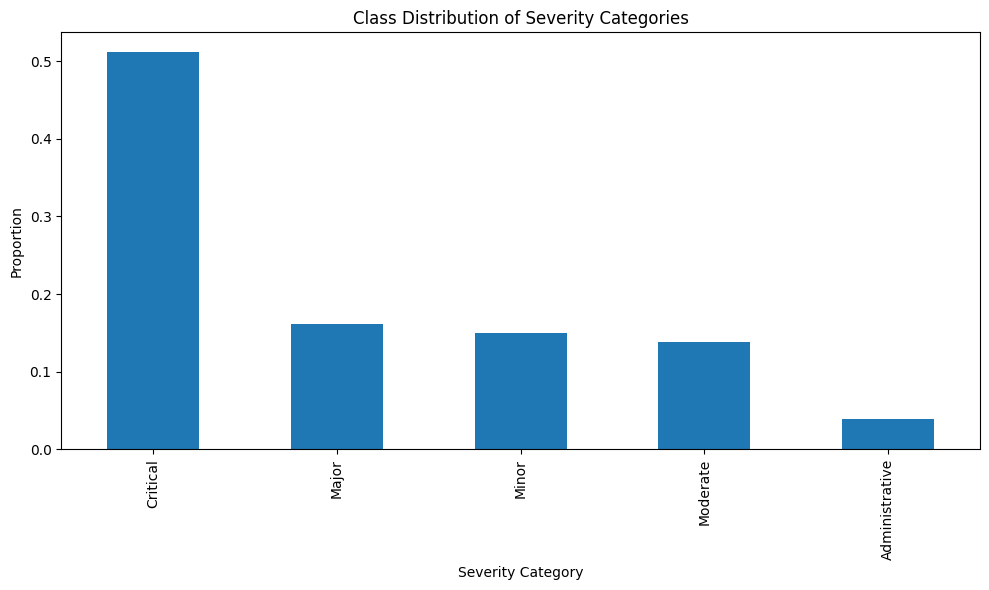

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre


Cross-validation Scores:
[0.21841898 0.2        0.2        0.22061187 0.2       ]
Mean CV Score: 0.2078 (+/- 0.0192)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report:
                precision    recall  f1-score   support

Administrative       0.05      0.07      0.06        94
      Critical       0.58      0.50      0.54      1248
         Major       0.22      0.26      0.24       394
         Minor       0.27      0.26      0.27       367
      Moderate       0.24      0.27      0.26       336

      accuracy                           0.38      2439
     macro avg       0.27      0.28      0.27      2439
  weighted avg       0.41      0.38      0.39      2439



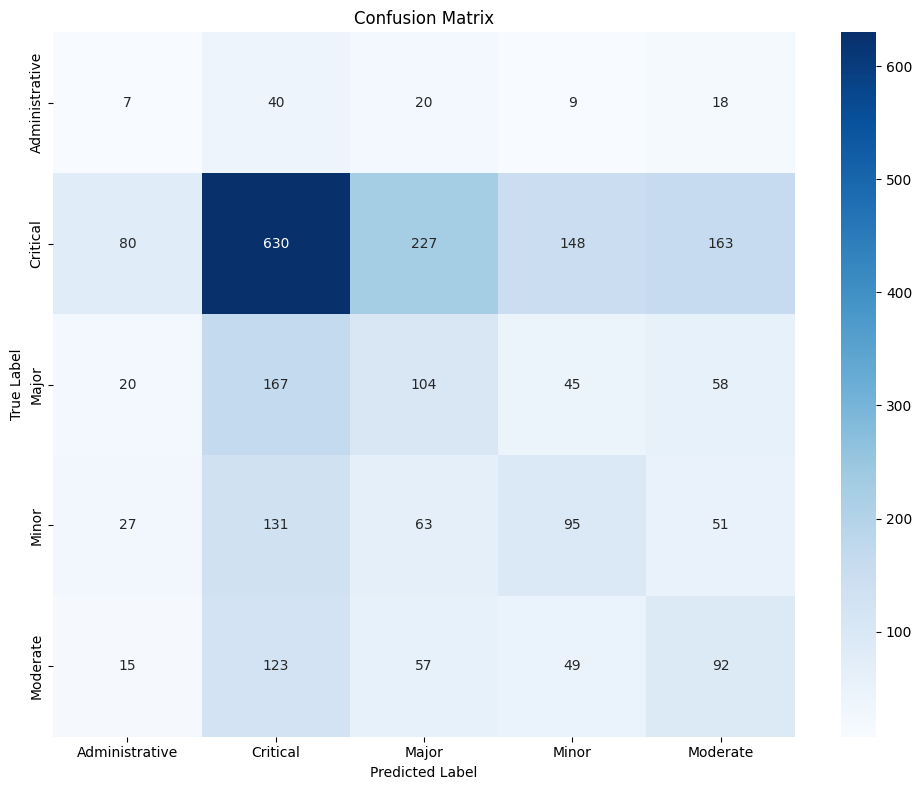

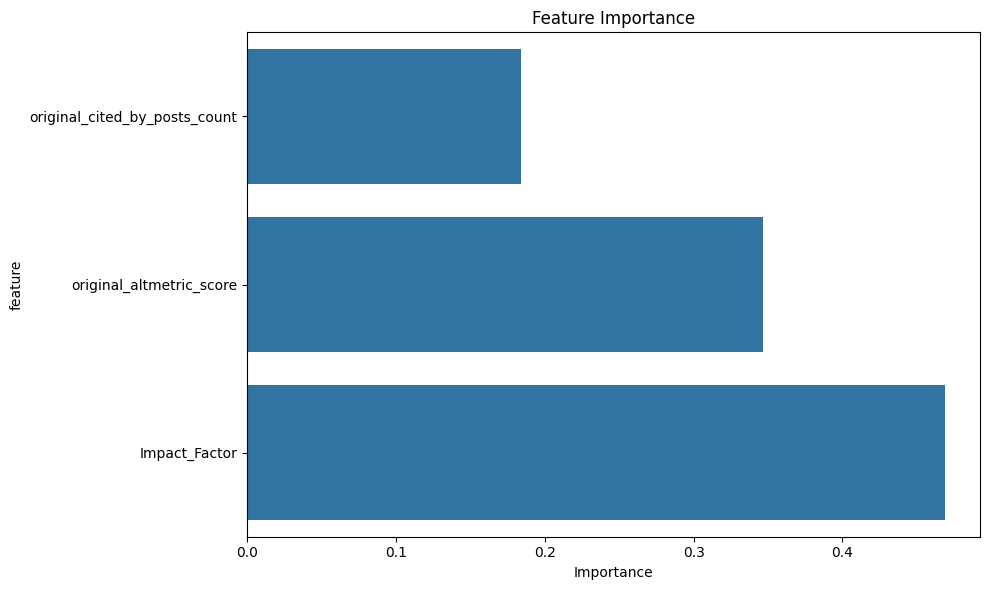

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1949
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

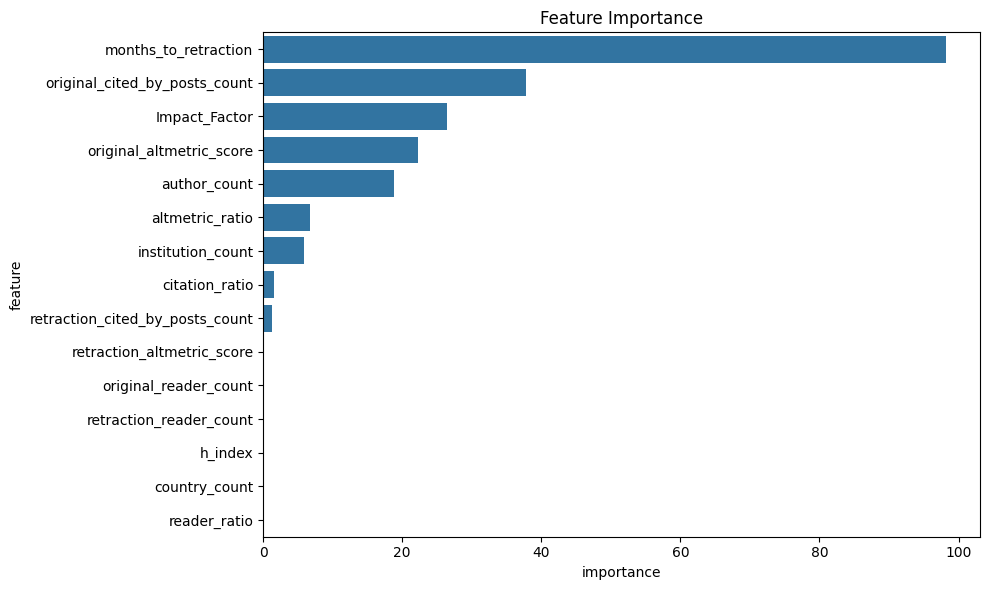


Feature Importance:
                            feature  importance
8              months_to_retraction   98.177419
0     original_cited_by_posts_count   37.869380
6                     Impact_Factor   26.495584
2          original_altmetric_score   22.243830
9                      author_count   18.884805
13                  altmetric_ratio    6.789205
10                institution_count    5.834660
12                   citation_ratio    1.529893
1   retraction_cited_by_posts_count    1.275460
3        retraction_altmetric_score    0.000000
4             original_reader_count    0.000000
5           retraction_reader_count    0.000000
7                           h_index    0.000000
11                    country_count    0.000000
14                     reader_ratio    0.000000

Ranked Sample Articles:
                                                                                                                                                                                          

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from datetime import datetime
import re
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns

def clean_impact_factor(value):
    if pd.isna(value):
        return 0.0
    if isinstance(value, str):
        # Handle '<X' cases
        if '<' in value:
            return float(value.replace('<', ''))
        # Handle other potential string cases
        try:
            return float(value)
        except:
            return 0.0
    return value

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def extract_features(df):
    # Create date features
    df['OriginalPaperDate'] = pd.to_datetime(df['OriginalPaperDate'])
    df['RetractionDate'] = pd.to_datetime(df['RetractionDate'])
    df['months_to_retraction'] = (df['RetractionDate'] - df['OriginalPaperDate']).dt.total_seconds() / (60*60*24*30.44)

    # Publication year and month
    df['publication_year'] = df['OriginalPaperDate'].dt.year
    df['publication_month'] = df['OriginalPaperDate'].dt.month

    # Count authors and institutions
    df['author_count'] = df['Author'].str.count(';') + 1
    df['institution_count'] = df['Institution'].str.count(';') + 1

    # Country features
    df['country_count'] = df['Country'].str.count(';') + 1

    # Clean Impact Factor
    df['Impact_Factor'] = df['Impact_Factor'].apply(clean_impact_factor)

    # Journal features (assuming these are from the original data)
    df['h_index'] = pd.to_numeric(df['h-index'], errors='coerce')

    # Citation and altmetric features
    citation_cols = ['original_cited_by_posts_count', 'retraction_cited_by_posts_count']
    altmetric_cols = ['original_altmetric_score', 'retraction_altmetric_score']
    reader_cols = ['original_reader_count', 'retraction_reader_count']

    for col in citation_cols + altmetric_cols + reader_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Calculate citation and altmetric ratios
    df['citation_ratio'] = df['retraction_cited_by_posts_count'] / (df['original_cited_by_posts_count'] + 1)
    df['altmetric_ratio'] = df['retraction_altmetric_score'] / (df['original_altmetric_score'] + 1)
    df['reader_ratio'] = df['retraction_reader_count'] / (df['original_reader_count'] + 1)

    # Create severity score mapping
    severity_map = {
        'Minor': 1,
        'Administrative': 2,
        'Moderate': 3,
        'Major': 4,
        'Critical': 5
    }
    df['severity_score'] = df['severity_category'].map(severity_map)

    # Select features for ranking
    feature_cols = [
        'original_cited_by_posts_count',
        'retraction_cited_by_posts_count',
        'original_altmetric_score',
        'retraction_altmetric_score',
        'original_reader_count',
        'retraction_reader_count',
        'Impact_Factor',
        'h_index',
        'months_to_retraction',
        'author_count',
        'institution_count',
        'country_count',
        'citation_ratio',
        'altmetric_ratio',
        'reader_ratio'
    ]

    # Handle missing values
    for col in feature_cols:
        df[col] = df[col].fillna(0)

    return df, feature_cols

def prepare_ranking_data(df, feature_cols):
    # Create query groups (we'll use years as groups)
    df['year'] = df['OriginalPaperDate'].dt.year

    # Normalize features
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    # Prepare data in ranking format
    X = df[feature_cols].values
    y = df['severity_score'].values
    groups = df['year'].values

    return X, y, groups

def train_ranking_model(X, y, groups, feature_cols):
    # Split data into train and validation
    gkf = GroupKFold(n_splits=5)
    train_idx, val_idx = next(gkf.split(X, y, groups))

    # Prepare LightGBM datasets
    train_data = lgb.Dataset(
        X[train_idx],
        label=y[train_idx],
        group=np.bincount(groups[train_idx])[1:],
        feature_name=feature_cols
    )

    val_data = lgb.Dataset(
        X[val_idx],
        label=y[val_idx],
        group=np.bincount(groups[val_idx])[1:],
        reference=train_data
    )

    # Parameters for LightGBM
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [5, 10],
        'learning_rate': 0.1,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 5.0,
        'num_threads': 4
    }

    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    return model, train_idx, val_idx

def evaluate_model(model, X, y, groups, val_idx):
    # Get predictions for validation set
    val_preds = model.predict(X[val_idx])

    # Calculate NDCG@k for different k values
    k_values = [5, 10]
    ndcg_scores = {}

    for k in k_values:
        ndcg = ndcg_score(
            y[val_idx].reshape(1, -1),
            val_preds.reshape(1, -1),
            k=k
        )
        ndcg_scores[f'ndcg@{k}'] = ndcg

    return ndcg_scores, val_preds

def analyze_feature_importance(model, feature_cols):
    # Get feature importance
    importance = model.feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return feature_importance

def rank_new_articles(model, df, feature_cols, n_articles=10):
    # Get random sample of articles
    sample_df = df.sample(n=n_articles)

    # Get predictions
    sample_features = sample_df[feature_cols].values
    predictions = model.predict(sample_features)

    # Add predictions to sample
    sample_df['predicted_score'] = predictions

    # Sort by predicted score
    ranked_articles = sample_df.sort_values('predicted_score', ascending=False)

    return ranked_articles[['Title', 'severity_category', 'reason_score', 'predicted_score'] + feature_cols]

# Main execution
def main():
    # Load and prepare data
    file_path = '/content/drive/MyDrive/wos_data/cleaned_dataset.csv'
    df = load_data(file_path)
    df, feature_cols = extract_features(df)

    # Prepare ranking data
    X, y, groups = prepare_ranking_data(df, feature_cols)

    # Train model
    model, train_idx, val_idx = train_ranking_model(X, y, groups, feature_cols)

    # Evaluate model
    ndcg_scores, val_preds = evaluate_model(model, X, y, groups, val_idx)
    print("\nModel Performance:")
    for metric, score in ndcg_scores.items():
        print(f"{metric}: {score:.4f}")

    # Analyze feature importance
    feature_importance = analyze_feature_importance(model, feature_cols)
    print("\nFeature Importance:")
    print(feature_importance)

    # Rank sample articles
    print("\nRanked Sample Articles:")
    ranked_articles = rank_new_articles(model, df, feature_cols)
    print(ranked_articles[['Title', 'severity_category', 'reason_score', 'predicted_score']].to_string())

    return model, df, feature_cols

if __name__ == "__main__":
    model, df, feature_cols = main()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 9755, number of used features: 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

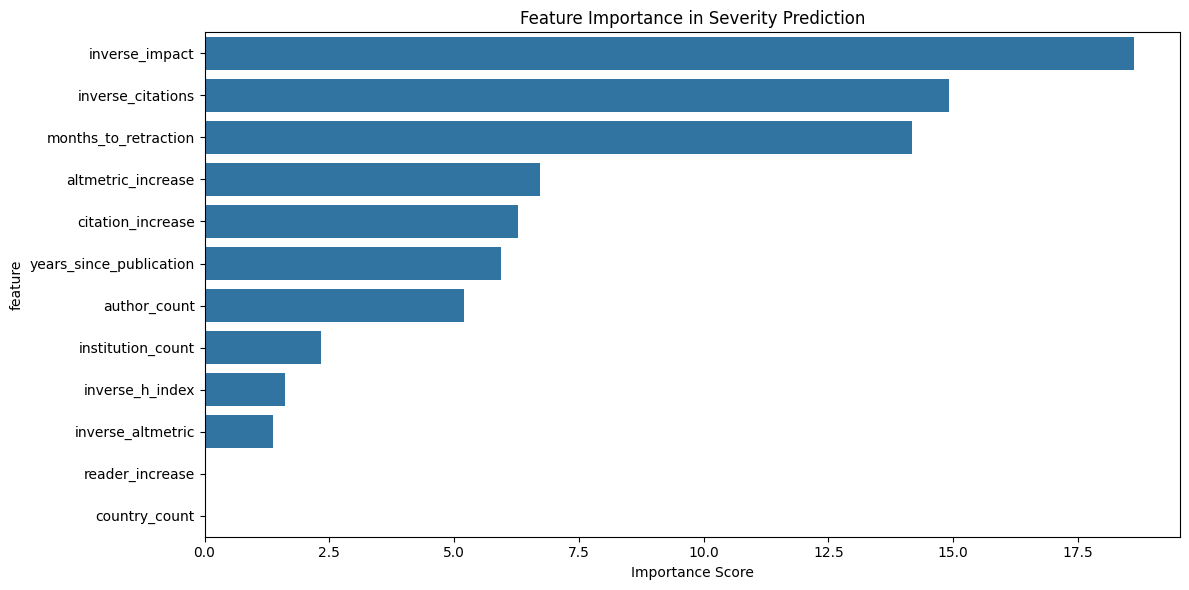


Model Performance:
ndcg@5: 0.9231
ndcg@10: 0.9231

Feature Importance:
                    feature  importance
2            inverse_impact   18.612880
0         inverse_citations   14.924237
7      months_to_retraction   14.184092
5        altmetric_increase    6.729713
4         citation_increase    6.288730
8   years_since_publication    5.945129
9              author_count    5.200723
10        institution_count    2.343310
3           inverse_h_index    1.614610
1         inverse_altmetric    1.378945
6           reader_increase    0.000000
11            country_count    0.000000

Ranked Sample Articles:
                                                                                                                                                                         Title severity_category  reason_score  predicted_score  original_cited_by_posts_count  original_altmetric_score  Impact_Factor
6869                                                                         Knockdown 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from datetime import datetime
import re
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns

def clean_impact_factor(value):
    if pd.isna(value):
        return 0.0
    if isinstance(value, str):
        if '<' in value:
            return float(value.replace('<', ''))
        try:
            return float(value)
        except:
            return 0.0
    return value

def extract_features(df):
    # Create date features
    df['OriginalPaperDate'] = pd.to_datetime(df['OriginalPaperDate'])
    df['RetractionDate'] = pd.to_datetime(df['RetractionDate'])
    df['months_to_retraction'] = (df['RetractionDate'] - df['OriginalPaperDate']).dt.total_seconds() / (60*60*24*30.44)

    # Publication features
    df['publication_year'] = df['OriginalPaperDate'].dt.year
    df['publication_month'] = df['OriginalPaperDate'].dt.month
    current_year = 2025  # As per the context date
    df['years_since_publication'] = current_year - df['publication_year']

    # Author and institution features
    df['author_count'] = df['Author'].str.count(';') + 1
    df['institution_count'] = df['Institution'].str.count(';') + 1
    df['country_count'] = df['Country'].str.count(';') + 1

    # Clean Impact Factor
    df['Impact_Factor'] = df['Impact_Factor'].apply(clean_impact_factor)
    df['h_index'] = pd.to_numeric(df['h-index'], errors='coerce').fillna(0)

    # Citation and attention metrics with time normalization
    metrics_cols = ['original_cited_by_posts_count', 'retraction_cited_by_posts_count',
                   'original_altmetric_score', 'retraction_altmetric_score',
                   'original_reader_count', 'retraction_reader_count']

    for col in metrics_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Normalize metrics by time
    df['citations_per_year'] = df['original_cited_by_posts_count'] / (df['years_since_publication'] + 1)
    df['altmetric_per_year'] = df['original_altmetric_score'] / (df['years_since_publication'] + 1)
    df['readers_per_year'] = df['original_reader_count'] / (df['years_since_publication'] + 1)

    # Create inverse metrics (assuming higher metrics might indicate less severity)
    df['inverse_citations'] = 1 / (df['citations_per_year'] + 1)
    df['inverse_altmetric'] = 1 / (df['altmetric_per_year'] + 1)
    df['inverse_impact'] = 1 / (df['Impact_Factor'] + 1)
    df['inverse_h_index'] = 1 / (df['h_index'] + 1)

    # Attention change ratios
    df['citation_increase'] = (df['retraction_cited_by_posts_count'] - df['original_cited_by_posts_count']) / (df['original_cited_by_posts_count'] + 1)
    df['altmetric_increase'] = (df['retraction_altmetric_score'] - df['original_altmetric_score']) / (df['original_altmetric_score'] + 1)
    df['reader_increase'] = (df['retraction_reader_count'] - df['original_reader_count']) / (df['original_reader_count'] + 1)

    # Map severity categories
    severity_map = {
        'Minor': 1,
        'Administrative': 2,
        'Moderate': 3,
        'Major': 4,
        'Critical': 5
    }
    df['severity_score'] = df['severity_category'].map(severity_map)

    # Select features for ranking
    feature_cols = [
        'inverse_citations',
        'inverse_altmetric',
        'inverse_impact',
        'inverse_h_index',
        'citation_increase',
        'altmetric_increase',
        'reader_increase',
        'months_to_retraction',
        'years_since_publication',
        'author_count',
        'institution_count',
        'country_count'
    ]

    # Handle missing values
    for col in feature_cols:
        df[col] = df[col].fillna(0)

    return df, feature_cols

def prepare_ranking_data(df, feature_cols):
    # Create query groups by year
    df['year'] = df['OriginalPaperDate'].dt.year

    # Normalize features
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    X = df[feature_cols].values
    y = df['severity_score'].values
    groups = df['year'].values

    return X, y, groups

def train_ranking_model(X, y, groups, feature_cols):
    gkf = GroupKFold(n_splits=5)
    train_idx, val_idx = next(gkf.split(X, y, groups))

    train_data = lgb.Dataset(
        X[train_idx],
        label=y[train_idx],
        group=np.bincount(groups[train_idx])[1:],
        feature_name=feature_cols
    )

    val_data = lgb.Dataset(
        X[val_idx],
        label=y[val_idx],
        group=np.bincount(groups[val_idx])[1:],
        reference=train_data
    )

    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [5, 10],
        'learning_rate': 0.1,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 5.0,
        'num_threads': 4
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    return model, train_idx, val_idx

def evaluate_and_analyze(model, X, y, groups, val_idx, feature_cols):
    # Get predictions
    val_preds = model.predict(X[val_idx])

    # Calculate NDCG scores
    ndcg_scores = {}
    for k in [5, 10]:
        ndcg = ndcg_score(
            y[val_idx].reshape(1, -1),
            val_preds.reshape(1, -1),
            k=k
        )
        ndcg_scores[f'ndcg@{k}'] = ndcg

    # Feature importance analysis
    importance = model.feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in Severity Prediction')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    return ndcg_scores, val_preds, feature_importance

def rank_new_articles(model, df, feature_cols, n_articles=10):
    sample_df = df.sample(n=n_articles)
    predictions = model.predict(sample_df[feature_cols].values)
    sample_df['predicted_score'] = predictions

    ranked_articles = sample_df.sort_values('predicted_score', ascending=False)

    display_cols = ['Title', 'severity_category', 'reason_score', 'predicted_score',
                   'original_cited_by_posts_count', 'original_altmetric_score', 'Impact_Factor']

    return ranked_articles[display_cols]

def main():
    file_path = '/content/drive/MyDrive/wos_data/cleaned_dataset.csv'
    df = pd.read_csv(file_path)
    df, feature_cols = extract_features(df)

    X, y, groups = prepare_ranking_data(df, feature_cols)
    model, train_idx, val_idx = train_ranking_model(X, y, groups, feature_cols)

    ndcg_scores, val_preds, feature_importance = evaluate_and_analyze(
        model, X, y, groups, val_idx, feature_cols
    )

    print("\nModel Performance:")
    for metric, score in ndcg_scores.items():
        print(f"{metric}: {score:.4f}")

    print("\nFeature Importance:")
    print(feature_importance)

    print("\nRanked Sample Articles:")
    ranked_articles = rank_new_articles(model, df, feature_cols)
    print(ranked_articles.to_string())

    return model, df, feature_cols

if __name__ == "__main__":
    model, df, feature_cols = main()

Loading data...
Extracting features...
Training model...
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@5: 0.996768	training's ndcg@10: 0.996867	training's map@5: 1	training's map@10: 1	valid_1's ndcg@5: 0.998953	valid_1's ndcg@10: 0.99901	valid_1's map@5: 1	valid_1's map@10: 1
Early stopping, best iteration is:
[1]	training's ndcg@5: 0.994	training's ndcg@10: 0.994847	training's map@5: 1	training's map@10: 1	valid_1's ndcg@5: 0.998983	valid_1's ndcg@10: 0.998874	valid_1's map@5: 1	valid_1's map@10: 1
Evaluating model...

Model Performance:
ndcg@5: 0.7896
ndcg@10: 0.7896
ndcg@20: 0.7896
spearman: 0.1502
kendall: 0.1294

Analyzing feature importance...


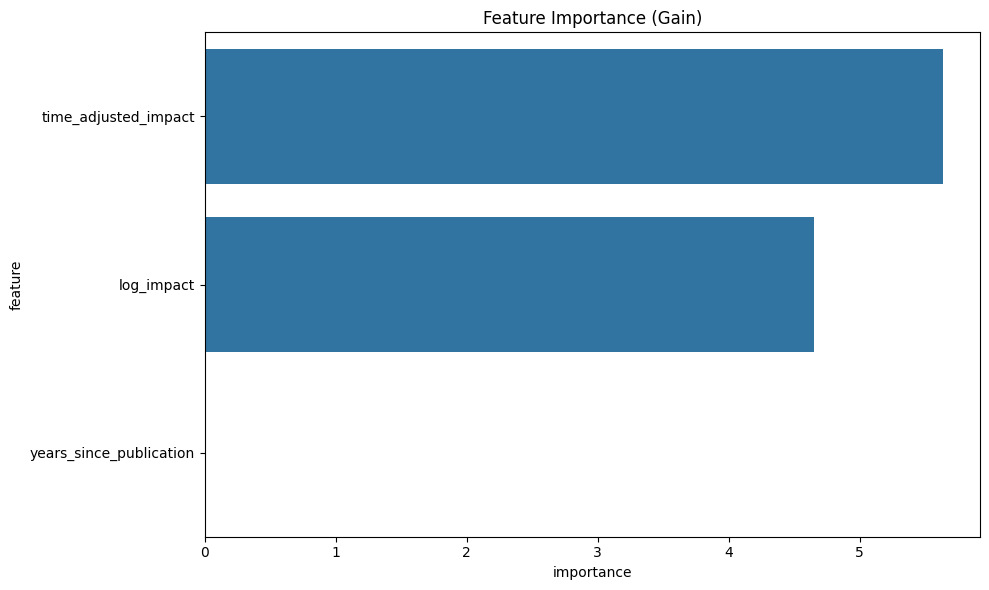


Feature Importance:
                   feature  importance
1     time_adjusted_impact    5.637754
0               log_impact    4.656070
2  years_since_publication    0.000000

Generating sample rankings...

Ranked Sample Articles:
                                                                                                                           Title severity_category predicted_severity  reason_score  predicted_score  Impact_Factor  original_cited_by_posts_count
8316                                          Epigenetic Regulator Polycomb Group Protein Complexes Control Cell Fate and Cancer          Critical                NaN           9.1         0.004759            4.5                            1.0
4508                                   Effect of miR-451 on the Biological Behavior of the Esophageal Carcinoma Cell Line EC9706          Critical                NaN          10.0         0.004759            2.5                            1.0
1312                               Fac

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from datetime import datetime
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

def clean_impact_factor(value):
    if pd.isna(value):
        return 0.0
    if isinstance(value, str):
        if '<' in value:
            return float(value.replace('<', ''))
        try:
            return float(value)
        except:
            return 0.0
    return value

def extract_features(df):
    # Create date features
    df['OriginalPaperDate'] = pd.to_datetime(df['OriginalPaperDate'])
    df['RetractionDate'] = pd.to_datetime(df['RetractionDate'])
    df['months_to_retraction'] = (df['RetractionDate'] - df['OriginalPaperDate']).dt.total_seconds() / (60*60*24*30.44)

    # Publication features
    df['publication_year'] = df['OriginalPaperDate'].dt.year
    current_year = 2025
    df['years_since_publication'] = current_year - df['publication_year']

    # Clean and transform metrics
    df['Impact_Factor'] = df['Impact_Factor'].apply(clean_impact_factor)

    # Log transformations with handling of zeros/negatives
    eps = 1e-8
    df['log_impact'] = np.log1p(df['Impact_Factor'] + eps)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + eps)

    # Time-weighted metrics
    time_factor = np.sqrt(df['years_since_publication'] + 1)
    df['time_adjusted_impact'] = df['Impact_Factor'] / time_factor
    df['time_adjusted_citations'] = df['original_cited_by_posts_count'] / time_factor

    # Map severity
    severity_map = {
        'Minor': 1,
        'Administrative': 2,
        'Moderate': 3,
        'Major': 4,
        'Critical': 5
    }
    df['severity_score'] = df['severity_category'].map(severity_map)

    # Select features
    feature_cols = [
        'log_impact',
        'time_adjusted_impact',
        'years_since_publication'
    ]

    # Handle missing values
    for col in feature_cols:
        df[col] = df[col].fillna(0)

    # Scale features
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    return df, feature_cols

def train_ranking_model(X, y, groups, feature_cols):
    gkf = GroupKFold(n_splits=5)
    train_idx, val_idx = next(gkf.split(X, y, groups))

    train_data = lgb.Dataset(
        X[train_idx],
        label=y[train_idx],
        group=np.bincount(groups[train_idx])[1:],
        feature_name=feature_cols
    )

    val_data = lgb.Dataset(
        X[val_idx],
        label=y[val_idx],
        group=np.bincount(groups[val_idx])[1:],
        reference=train_data
    )

    params = {
        'objective': 'lambdarank',
        'metric': ['ndcg', 'map'],
        'ndcg_eval_at': [5, 10],
        'learning_rate': 0.01,
        'num_leaves': 7,
        'max_depth': 3,
        'min_data_in_leaf': 50,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 0.5,
        'lambda_l2': 0.5,
        'min_gain_to_split': 0.2,
        'verbose': -1
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[train_data, val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    return model, train_idx, val_idx

def evaluate_model(model, X, y, val_idx):
    val_preds = model.predict(X[val_idx])

    metrics = {}
    for k in [5, 10, 20]:
        metrics[f'ndcg@{k}'] = ndcg_score(
            y[val_idx].reshape(1, -1),
            val_preds.reshape(1, -1),
            k=k
        )

    spearman_corr, _ = spearmanr(y[val_idx], val_preds)
    kendall_corr, _ = kendalltau(y[val_idx], val_preds)
    metrics['spearman'] = spearman_corr
    metrics['kendall'] = kendall_corr

    return metrics, val_preds

def analyze_feature_importance(model, feature_cols):
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importance(importance_type='gain')
    })
    importance_df = importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Feature Importance (Gain)')
    plt.tight_layout()
    plt.show()

    return importance_df

def rank_new_articles(model, df, feature_cols, n_articles=10):
    sample_df = df.sample(n=n_articles)
    predictions = model.predict(sample_df[feature_cols].values)

    sample_df['predicted_score'] = predictions

    # Use rank with method='first' to handle ties
    rank_pct = pd.Series(predictions).rank(pct=True, method='first')

    # Define severity based on rank percentiles
    sample_df['predicted_severity'] = pd.cut(
        rank_pct,
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['Minor', 'Administrative', 'Moderate', 'Major', 'Critical'],
        include_lowest=True
    )

    ranked_articles = sample_df.sort_values('predicted_score', ascending=False)

    display_cols = [
        'Title',
        'severity_category',
        'predicted_severity',
        'reason_score',
        'predicted_score',
        'Impact_Factor',
        'original_cited_by_posts_count'
    ]

    return ranked_articles[display_cols]

def main():
    # Load data
    file_path = '/content/drive/MyDrive/wos_data/cleaned_dataset.csv'
    print("Loading data...")
    df = pd.read_csv(file_path)

    # Extract features
    print("Extracting features...")
    df, feature_cols = extract_features(df)

    # Prepare data
    X = df[feature_cols].values
    y = df['severity_score'].values
    groups = df['publication_year'].values

    # Train model
    print("Training model...")
    model, train_idx, val_idx = train_ranking_model(X, y, groups, feature_cols)

    # Evaluate
    print("Evaluating model...")
    metrics, val_preds = evaluate_model(model, X, y, val_idx)
    print("\nModel Performance:")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

    # Analyze importance
    print("\nAnalyzing feature importance...")
    importance_df = analyze_feature_importance(model, feature_cols)
    print("\nFeature Importance:")
    print(importance_df)

    # Rank examples
    print("\nGenerating sample rankings...")
    ranked_articles = rank_new_articles(model, df, feature_cols)
    print("\nRanked Sample Articles:")
    print(ranked_articles.to_string())

    return model, df, feature_cols

if __name__ == "__main__":
    model, df, feature_cols = main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from datetime import datetime
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

def preprocess_text(text):
    """Clean and preprocess text data."""
    if pd.isna(text):
        return ""

    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

def extract_title_features(df):
    """Extract features from paper titles."""
    # Preprocess titles
    df['cleaned_title'] = df['Title'].apply(preprocess_text)

    # TF-IDF features
    tfidf = TfidfVectorizer(
        max_features=100,
        stop_words='english',
        ngram_range=(1, 2)
    )

    # Get TF-IDF matrix
    title_features = tfidf.fit_transform(df['cleaned_title'])

    # Convert to DataFrame
    title_feature_names = [f'title_tfidf_{i}' for i in range(title_features.shape[1])]
    title_features_df = pd.DataFrame(
        title_features.toarray(),
        columns=title_feature_names
    )

    # Basic text statistics
    df['title_word_count'] = df['cleaned_title'].apply(lambda x: len(x.split()))
    df['title_unique_word_count'] = df['cleaned_title'].apply(lambda x: len(set(x.split())))
    df['title_word_density'] = df['title_unique_word_count'] / (df['title_word_count'] + 1)

    return pd.concat([df, title_features_df], axis=1), title_feature_names

def clean_impact_factor(value):
    """Clean impact factor values."""
    if pd.isna(value):
        return 0.0
    if isinstance(value, str):
        if '<' in value:
            return float(value.replace('<', ''))
        try:
            return float(value)
        except:
            return 0.0
    return value

def extract_features(df):
    """Extract all features from the dataset."""
    # Create date features
    df['OriginalPaperDate'] = pd.to_datetime(df['OriginalPaperDate'])
    df['RetractionDate'] = pd.to_datetime(df['RetractionDate'])

    # Time-based features
    df['months_to_retraction'] = (df['RetractionDate'] - df['OriginalPaperDate']).dt.total_seconds() / (60*60*24*30.44)
    df['publication_year'] = df['OriginalPaperDate'].dt.year
    df['publication_month'] = df['OriginalPaperDate'].dt.month
    current_year = 2025
    df['years_since_publication'] = current_year - df['publication_year']

    # Clean and transform metrics
    df['Impact_Factor'] = df['Impact_Factor'].apply(clean_impact_factor)

    # Extract title features
    df, title_feature_names = extract_title_features(df)

    # Advanced feature engineering
    eps = 1e-8
    df['log_impact'] = np.log1p(df['Impact_Factor'] + eps)
    df['log_citations'] = np.log1p(df['original_cited_by_posts_count'] + eps)

    # Interaction features
    df['impact_citation_ratio'] = df['Impact_Factor'] / (df['original_cited_by_posts_count'] + 1)
    df['citations_per_year'] = df['original_cited_by_posts_count'] / (df['years_since_publication'] + 1)

    # Time-weighted metrics
    time_factor = np.sqrt(df['years_since_publication'] + 1)
    df['time_adjusted_impact'] = df['Impact_Factor'] / time_factor
    df['time_adjusted_citations'] = df['original_cited_by_posts_count'] / time_factor

    # Severity mapping with balanced weights
    severity_counts = df['severity_category'].value_counts()
    severity_weights = {
        category: 1 / (count / len(df))
        for category, count in severity_counts.items()
    }

    severity_map = {
        'Minor': 1,
        'Administrative': 2,
        'Moderate': 3,
        'Major': 4,
        'Critical': 5
    }
    df['severity_score'] = df['severity_category'].map(severity_map)
    df['severity_weight'] = df['severity_category'].map(severity_weights)

    # Select features
    base_features = [
        'log_impact',
        'log_citations',
        'time_adjusted_impact',
        'time_adjusted_citations',
        'impact_citation_ratio',
        'citations_per_year',
        'years_since_publication',
        'months_to_retraction',
        'publication_month',
        'title_word_count',
        'title_unique_word_count',
        'title_word_density'
    ]

    feature_cols = base_features + title_feature_names

    # Handle missing values
    for col in feature_cols:
        df[col] = df[col].fillna(df[col].median())

    # Scale features
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    return df, feature_cols

def train_ranking_model(X, y, groups, weights, feature_cols):
    """Train the ranking model with cross-validation."""
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    weights = np.array(weights)

    gkf = GroupKFold(n_splits=5)
    scores = []
    models = []

    # Cross validation
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
        print(f"\nTraining fold {fold + 1}/5...")

        train_data = lgb.Dataset(
            X[train_idx],
            label=y[train_idx],
            weight=weights[train_idx],
            group=np.bincount(groups[train_idx])[1:],
            feature_name=feature_cols
        )

        val_data = lgb.Dataset(
            X[val_idx],
            label=y[val_idx],
            weight=weights[val_idx],
            group=np.bincount(groups[val_idx])[1:],
            reference=train_data
        )

        params = {
            'objective': 'lambdarank',
            'metric': ['ndcg', 'map'],
            'ndcg_eval_at': [5, 10, 20],
            'learning_rate': 0.003,
            'num_leaves': 63,
            'max_depth': 8,
            'min_data_in_leaf': 20,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.05,
            'lambda_l2': 0.05,
            'min_gain_to_split': 0.05,
            'verbose': -1
        }

        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[train_data, val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=150),
                lgb.log_evaluation(period=100)
            ]
        )

        # Evaluate fold
        val_preds = model.predict(X[val_idx])
        fold_metrics = calculate_metrics(y[val_idx], val_preds)
        scores.append(fold_metrics)
        models.append((model, val_idx))

        print(f"Fold {fold + 1} metrics:")
        for metric, score in fold_metrics.items():
            print(f"{metric}: {score:.4f}")

    # Select best model
    best_idx = np.argmax([s['ndcg@10'] for s in scores])
    best_model, best_val_idx = models[best_idx]

    print(f"\nSelected best model from fold {best_idx + 1}")

    return best_model, best_val_idx, scores

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive ranking metrics."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {}

    # NDCG at different k
    for k in [5, 10, 20, 50]:
        metrics[f'ndcg@{k}'] = ndcg_score(
            y_true.reshape(1, -1),
            y_pred.reshape(1, -1),
            k=k
        )

    # Correlation metrics
    spearman_corr, _ = spearmanr(y_true, y_pred)
    kendall_corr, _ = kendalltau(y_true, y_pred)
    metrics['spearman'] = spearman_corr
    metrics['kendall'] = kendall_corr

    # Ranking metrics
    y_true_ranks = pd.Series(y_true).rank()
    y_pred_ranks = pd.Series(y_pred).rank()
    metrics['rank_mae'] = np.mean(np.abs(y_true_ranks - y_pred_ranks))

    return metrics

def evaluate_model(model, X, y, val_idx, feature_cols):
    """Evaluate model performance and analyze feature importance."""
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    val_idx = np.array(val_idx)

    # Ensure val_idx is boolean or integer array
    if val_idx.dtype == bool:
        val_preds = model.predict(X[val_idx])
        val_true = y[val_idx]
    else:
        val_preds = model.predict(X[val_idx.astype(int)])
        val_true = y[val_idx.astype(int)]

    # Calculate metrics
    metrics = calculate_metrics(val_true, val_preds)

    # Feature importance analysis
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importance(importance_type='gain')
    })

    # Add feature categories
    def get_feature_category(feature_name):
        if feature_name.startswith('title_tfidf_'):
            return 'Title TF-IDF'
        elif feature_name.startswith('title_'):
            return 'Text Statistics'
        elif 'citation' in feature_name:
            return 'Citation Metrics'
        elif 'impact' in feature_name:
            return 'Impact Metrics'
        else:
            return 'Temporal Features'

    importance_df['category'] = importance_df['feature'].apply(get_feature_category)
    importance_df = importance_df.sort_values('importance', ascending=False)

    # Calculate category importance
    category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

    # Visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Top 20 features
    plt.subplot(2, 1, 1)
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 20 Feature Importance (Gain)')

    # Plot 2: Category importance
    plt.subplot(2, 1, 2)
    sns.barplot(x=category_importance.values, y=category_importance.index)
    plt.title('Feature Category Importance')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nDetailed Model Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nTop 10 Most Important Features:")
    print(importance_df[['feature', 'importance', 'category']].head(10))

    return metrics, val_preds, importance_df, category_importance

def rank_new_articles(model, df, feature_cols, n_articles=10):
    """Generate rankings for new articles."""
    sample_df = df.sample(n=n_articles)
    predictions = model.predict(sample_df[feature_cols].values)

    sample_df['predicted_score'] = predictions

    # Calculate confidence scores
    rank_pct = pd.Series(predictions).rank(pct=True, method='first')

    # Define severity with confidence threshold
    severity_thresholds = [0.2, 0.4, 0.6, 0.8]
    severity_labels = ['Minor', 'Administrative', 'Moderate', 'Major', 'Critical']

    sample_df['predicted_severity'] = pd.cut(
        rank_pct,
        bins=[0] + severity_thresholds + [1.0],
        labels=severity_labels,
        include_lowest=True
    )

    sample_df['confidence_score'] = abs(0.5 - abs(rank_pct - 0.5)) * 2

    ranked_articles = sample_df.sort_values('predicted_score', ascending=False)

    display_cols = [
        'Title',
        'severity_category',
        'predicted_severity',
        'confidence_score',
        'reason_score',
        'predicted_score',
        'Impact_Factor',
        'original_cited_by_posts_count'
    ]

    return ranked_articles[display_cols]

def main():
    """Main execution function."""
    # Download required NLTK data
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')

    # Load data
    print("Loading data...")
    df = pd.read_csv('your_data.csv')  # Replace with your file path

    # Print class distribution
    print("\nClass Distribution:")
    print(df['severity_category'].value_counts(normalize=True))

    # Extract features
    print("\nExtracting features...")